# Algebra of Failure Inducing Input Patterns

## What

We are trying to generate grammars that produce inputs that contain or does not specific behaviors (or complex combinations thereof) so, one can say things of the sort: I want to generate inputs with parenthesis, but discard everything with doubled parenthesis.

While boolean grammars are the formalism for such things (e.g A & B & !C), and one can trivially construct multi-level recognizers for it (parse A, parse B, not parse C), generation is much harder, and as far as I can see, no one has found a way to easily generate inputs from such expressions (other than the generate and filter approach, which is really inefficient). Further, the boolean grammars are already beyond context free grammars, and our current techniques such as annotation of probabilities, and feedback on grammar nodes will not work on them. What we do here, is to recognize that for fault pattern additions and removal, one can stick to a context-free subset, and one can guarantee the properties of the resulting grammar.

Other things we can likely do: Generate grammars that produce a given prefix or a given suffix, and combinations of those.

## Why

It is often necessary to include multiple patterns in an input to trigger a fault. For example, a certain fault may occur only if a particular element is seen in advance, or a fault induced early on may only be triggered by a later element. Similarly, one may want to specify that a particular code element is covered, as well as a particular input element be/not be present (e.g. on bugfixes). Finally, one may also want to avoid triggering bugs that are already known.

## How

We first extract the abstract syntactical patterns that correspond to given behaviors, and then generate a refinement grammar from the original grammar that follows the algebraic specifications.

The main question being asked is, how to combine and negate fault patterns.

We use `~F` for a nonterminal that is guaranteed not to contain a given fault, and `+F` for a nonterminal that is guaranteed to contain at least one instance of the given fault.

## How is it done?

We start with the concept of an _abstract pattern_ form `DDSet`.

### Abstract Pattern

An _abstract pattern_ is a parse tree of a fault inducing input such that all non-causal subtrees are marked abstract. From an _abstract pattern_ we derive its _charecteristic node_.

#### Charecteristic node

A _charecteristic node_ of an _abstract pattern_ is the smallest subtree (and the corresponding node) that completely captures the concrete _terminal_ symbols in the _abstract pattern_.

#### Linear grammar of a parse tree

A _linear grammar_ of a parse tree is a grammar such that the grammar can produce only the given parse tree. It is constructed by marking each node in the parse tree with a unique suffix, and extracting the grammar of the suffixed tree. The _linear grammar_ of the _charecteristic node_ will produce the _exact_ string that produced the fault. The start symbol of the grammar is the nonterminal of the characteristic node.

#### Linear abstract grammar

This is derived from the _linear grammar_ of the _characteristic node_ where the nonterminals in the grammar that correspond to abstract nodes are replaced by the non-suffixed general nonterminals in the original grammar. The start symbol of the linear abstract grammar remains the same as the linear grammar of the characteristic node. The important thing to note here is that if one wishes to reproduce the given fault, the parse tree __should contain__ the nonterminals of the linear abstract grammar.

#### Negated linear abstract grammar

The linear abstract grammar for a fault is constructed from the linear abstract grammar of that fault by replacing the definitions one token at a time with a nonterminal guaranteed not to match the particular expansion in the linear grammar. To this set of rules is added the definitions from the original grammar that did not match the linear grammar.


```
<X> := <A> <B>
<A> := A
     | a <C>
<B> := B
     | b
<C> := C
     | C
```
Say the linear grammar is:
```
<X> := <A_1> <B_2>
<A_1> := a <C_3>
<B_2> := b
<C_3> := c
```

Then, the negated linear grammar is (we define it using the symbol `^F` to avoid confusing with `+F`) --- The difference is that `+F` guarantees the full fault, while `^F` represents a partial fault.
```
<^X> := <^A_1> <B_2>
      | <A_1> <^B_2>
<A_1> := a <C_3>
       | A
<^A_1> := a <^C_3>
        | A
<B_2> := b
<^B_2> := B
<C_3> := c
<^C_3> := C
```
If a particular nonterminal cannot be negated, then the rules that use that negated nonterminal is removed, and the nonterminals that have no rules are removed recursively.

#### Grammar with the guarantee that at least one instance of the fault will always be present (G+).

We mark nonterminals that are guaranteed to contain at least a given single fault as `+F` and those nodes that are guaranteed to not contain that fault as `~F` where `<F>` is the original nonterminal.

Given a grammar that starts with 

```
<start> := <A> <B> <C>
         ...
```
    
The grammar will contain at least a single fault if that single rule is replaced by this set of rules

```
<1start> := <+A> <B> <C>
         | <A> <+B> <C>
         | <A> <B> <+C>
...
```
Similarly, if one assumes that the nonterminal `<A>` can contain faults, and it has the following rules (nonterminals indicated by `<..>`)
```
<A> := x <P> <P> x
     | x <P> x
```
then, the following definition is guaranteed to produce at least one instance of the fault in any expansion
```
<1A> := x <+P> <P> x
     | x <P> <+P> x
     | x <+P> x
```

#### Grammar with the guarantee that no instance of the fault will be present (G-)

Negation is simply negation of all nonterminals
```
<~A> := x <~P> <~P>
      | x <~P>
```

#### Grammar with the guarantee that at most one instance of the fault will be present (G*)

```
<1start> := <A> <~B> <~C>
         | <~A> <B> <~C>
         | <~A> <~B> <C>
...
```

#### Grammar with the guarantee that exactly one instance of the fault will be present

```
G_1 = G+ & G*
```

#### Base cases

There are two base cases for this recursion. The first is when the nonterminal is the charecteristic node of the fault being inserted. In this case, the definition `<+F>` is simply the start symbol of the linear abstract grammar (and the linear abstract grammar is merged into the grammar). Similarly with the negation terminal.

The second base case is when the nonterminal cannot produce the fault (e.g `<digit>` for producing a parenthesis). Here, the solution is simple. The nonterminal `<+F>` is defined as empty, and the rules that use that nonterminal is removed, and the nonterminals with empty rules are removed recursively as before. The negation `<~F>` is simply `<F>` because it is guaranteed not to produce a fault.

### (|) two refined grammars.

We generate grammars with the faults on boths sides. Next, we merge the grammars. Next, we remove any rule from the definition that is more refined than another rule in the same definition. A rule is more refined than another rule if 1) they both were derived from the same original rule from the original grammar (checked by looking at the stems and terminals) and 2) for any given token, the token at the same position of the other rule has a superset expansion. E.g a digit with expansion `[2, 4]` is a refinement of a digit with expansion `[1, 2, 3, 4, 5]`. (The fixpoint is computed). (This means that the disjunction of the original grammar with any fault inducing grammar will always be the original grammar.)

### (&) two refined grammars.

Conjunction of two refined grammars is simply the conjunction of both start symbols. The conjunction of two matching (same stem) nonterminals is a conjunction of their matching rules (match with the same terminals and stem of nonterminals). Conjunction of two rules is single rule with each nonterminal representing a conjunction of two corresponding nonterminals at the corresponding places from the two rules. When there are multiple matching rules, the rules produced are all pairs.

Note that one can generate an `atleast one fault grammar` (by skipping negation in the exactly one fault grammar) and an `atmost one fault grammar` (by skipping fault insertion in the exactly one fault grammar), and generate the `exactly one fault grammar` by generating a conjunction of both.

## Limitations

The limitations are as follows:
1. Only applicable to deterministic grammars (at least deterministic parts of the grammar)
2. The fault patterns are neither sound nor complete w.r.t the failure (this is a limitation of the ddset fault pattern). 
   i.e:
   The same failure may result from different patterns. Hence, negating one pattern does not mean negating that failure fully (not complete)
   The same pattern in a different context may not result in a failure (not sound)
4. Adding new fault patterns results in almost exponential increase (worst case) in the grammar rules of corresponding non terminals.
5. We assume that rules for a nonterminal are non-redundant (If the same rule is repeated with same nonterminals, we can statically remove the more refined rule. If the nonterminals used are different, then it falls afoul of the deterministic grammar requirement).

The faults can from several different inputs. The idea is that the characterizing node, and abstraction removes the influences of the specific parse tree.

## Fault Patterns

We define an input from which we extract our patterns. Note that we do not use the predicate; rather we assume that we already have a few such predicates.

In [1]:
expr_input =  '1 + ((2 * 3 / 4))'

### Grammar

A context-free grammar is represented as a Python dict, with each nonterminal symbol forming a key, and each nonterminal _defined_ by a list of expansion rules. For example, the expression grammar for parsing arithmetic expressions is given below.

In [2]:
EXPR_GRAMMAR = {'<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9']]}

In [3]:
EXPR_START = '<start>'

Note the convetion we used: Each nonterminal is enclosed in angle brackets. E.g. `<expr>`. We now define a function that can distinguish terminal symbols from nonterminals.

The `is_nt()` function checks if the given node is a terminal or not.

In [4]:
def is_nt(symbol):
     return symbol and (symbol[0], symbol[-1]) == ('<', '>')

#### The Parser

Given the grammar, and an input, we can parse it into a derivation tree.
The `Parser` below is from [fuzzingbook.org](https://www.fuzzingbook.org/html/Parser.html), and provides a generic context-free parser. This is present in the `src` directory.

In [5]:
from Parser import EarleyParser as Parser

How do we check that our parse succeeded? We can convert the derivation tree back to the original string and check for equality.

The `tree_to_str()` function converts a derivation tree to its original string.

In [6]:
def tree_to_str(node):
    name, children, *rest = node
    if not children:
        return name
    return ''.join([tree_to_str(c) for c in children])

In [7]:
def tree_to_str(tree):
    expanded = []
    to_expand = [tree]
    while to_expand:
        (key, children, *rest), *to_expand = to_expand
        if is_nt(key):
            #assert children # not necessary
            to_expand = list(children) + list(to_expand)
        else:
            assert not children
            expanded.append(key)
    return ''.join(expanded)

In [8]:
Ts = tree_to_str

In [9]:
expr_parser = Parser(EXPR_GRAMMAR, start_symbol=EXPR_START, canonical=True)
expr_tree = list(expr_parser.parse(expr_input))[0]
assert tree_to_str(expr_tree) == '1 + ((2 * 3 / 4))'

#### Display

While converting to strings are easy, it is unsatisfying. We want to make our output look pretty, and inspect the tree structure of the parsed tree. So we define graphical tree display (code from fuzzingbook)

In [10]:
from graphviz import Digraph

In [11]:
from IPython.display import display, Image

In [12]:
def zoom(v, zoom=True):
    # return v directly if you do not want to zoom out.
    if zoom:
        return Image(v.render(format='png'))
    return v

In [13]:
class DisplayTree():
    def __init__(self):
        pass

    def extract_node(self, node, id):
        symbol, children, *annotation = node
        return symbol, children, ''.join(str(a) for a in annotation)
    
    def node_attr(self, dot, nid, symbol, ann):
        dot.node(repr(nid), symbol + ' ')
        
    def edge_attr(self, dot, start_node, stop_node):
        dot.edge(repr(start_node), repr(stop_node))
        
    def graph_attr(self, dot):
        dot.attr('node', shape='plain')
        
    def display(self, derivation_tree):
        counter = 0
        def traverse_tree(dot, tree, id=0):
            (symbol, children, annotation) = self.extract_node(tree, id)
            self.node_attr(dot, id, symbol, annotation)
            if children:
                for child in children:
                    nonlocal counter
                    counter += 1
                    child_id = counter
                    self.edge_attr(dot, id, child_id)
                    traverse_tree(dot, child, child_id)
        dot = Digraph(comment="Derivation Tree")
        self.graph_attr(dot)
        traverse_tree(dot, derivation_tree)
        return dot
    
    def __call__(self, dt):
        return self.display(dt)

In [14]:
display_tree = DisplayTree()

We are now ready to display the tree structure.

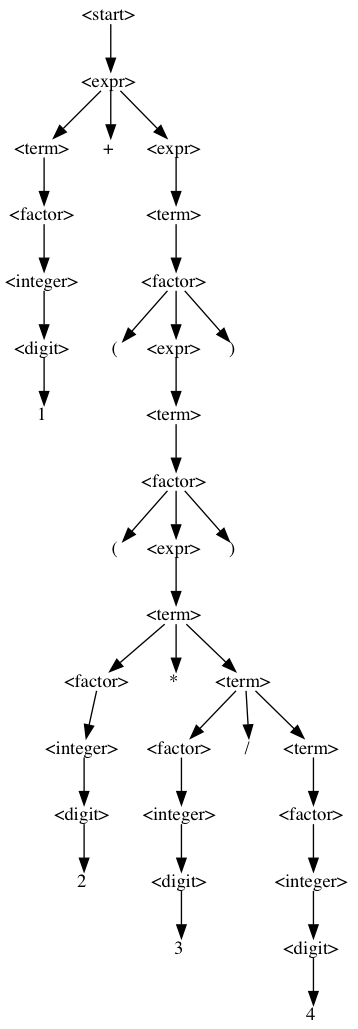

In [15]:
zoom(display_tree(expr_tree))

#### A Fuzzer

In order to define abstraction, we need to be able to generate values based on a grammar. Our fuzzer is able to do that.

In [16]:
import random

##### The interface

In [17]:
class Fuzzer:
    def __init__(self, grammar):
        self.grammar = grammar

    def fuzz(self, key='<start>', max_num=None, max_depth=None):
        raise NotImplemented()

##### The implementation

The fuzzer tries to randomly choose an expansion when more than one expansion is available. If however, it goes beyond max_depth, then it chooses the cheapest nodes. The cheapest nodes are those nodes with minimum further expansion (no recursion).

In [18]:
class LimitFuzzer(Fuzzer):
    def symbol_cost(self, grammar, symbol, seen):
        if symbol in self.key_cost: return self.key_cost[symbol]
        if symbol in seen:
            self.key_cost[symbol] = float('inf')
            return float('inf')
        v = min((self.expansion_cost(grammar, rule, seen | {symbol})
                    for rule in grammar.get(symbol, [])), default=0)
        self.key_cost[symbol] = v
        return v

    def expansion_cost(self, grammar, tokens, seen):
        return max((self.symbol_cost(grammar, token, seen)
                    for token in tokens if token in grammar), default=0) + 1

    def nonterminals(self, rule):
        return [t for t in rule if self.is_nt(t)]

    def iter_gen_key(self, key, max_depth):
        def get_def(t):
            if self.is_nt(t):
                return [t, None]
            else:
                return [t, []]

        cheap_grammar = {}
        for k in self.cost:
            # should we minimize it here? We simply avoid infinities
            rules = self.grammar[k]
            min_cost = min([self.cost[k][str(r)] for r in rules])
            #grammar[k] = [r for r in grammar[k] if self.cost[k][str(r)] == float('inf')]
            cheap_grammar[k] = [r for r in self.grammar[k] if self.cost[k][str(r)] == min_cost]

        root = [key, None]
        queue = [(0, root)]
        while queue:
            # get one item to expand from the queue
            (depth, item), *queue = queue
            key = item[0]
            if item[1] is not None: continue
            grammar = self.grammar if depth < max_depth else cheap_grammar
            chosen_rule = random.choice(grammar[key])
            expansion = [get_def(t) for t in chosen_rule]
            item[1] = expansion
            for t in expansion: queue.append((depth+1, t))
            #print("Fuzz: %s" % key, len(queue), file=sys.stderr)
        #print(file=sys.stderr)
        return root

    def gen_key(self, key, depth, max_depth):
        if key not in self.grammar:
            return (key, [])
        if depth > max_depth:
            #return self.gen_key_cheap_iter(key)
            clst = sorted([(self.cost[key][str(rule)], rule) for rule in self.grammar[key]])
            rules = [r for c,r in clst if c == clst[0][0]]
        else:
            rules = self.grammar[key]
        return (key, self.gen_rule(random.choice(rules), depth+1, max_depth))

    def gen_rule(self, rule, depth, max_depth):
        return [self.gen_key(token, depth, max_depth) for token in rule]

    def fuzz(self, key='<start>', max_depth=10):
        self._s = self.iter_gen_key(key=key, max_depth=max_depth)
        return self.tree_to_str(self._s)
   
    def is_nt(self, name):
        return (name[0], name[-1]) == ('<', '>')
 
    def tree_to_str(self, tree):
        name, children = tree
        if not self.is_nt(name): return name
        return ''.join([tree_to_str(c) for c in children])

    def tree_to_str(self, tree):
        expanded = []
        to_expand = [tree]
        while to_expand:
            (key, children, *rest), *to_expand = to_expand
            if is_nt(key):
                #assert children # not necessary
                to_expand = children + to_expand
            else:
                assert not children
                expanded.append(key)
        return ''.join(expanded)


    def __init__(self, grammar):
        super().__init__(grammar)
        self.key_cost = {}
        self.cost = self.compute_cost(grammar)

    def compute_cost(self, grammar):
        cost = {}
        for k in grammar:
            cost[k] = {}
            for rule in grammar[k]:
                cost[k][str(rule)] = self.expansion_cost(grammar, rule, set())
            if len(grammar[k]):
                assert len([v for v in cost[k] if v != float('inf')]) > 0
        return cost

In [19]:
fuzzer_expr = LimitFuzzer(EXPR_GRAMMAR)
fuzzer_expr.fuzz(EXPR_START)

'(----0 * (2.8 - 7 + 8) * 2 * -7.0 * 4.6 - --+5 / --7.2 / 1 * 1 * 0.3) - 8.634 / +4237 / --++5.7 + -(-9.6) * 130.7'

### Library functions

In [20]:
def copy_grammar(g):
    return {k:[[t for t in r] for r in g[k]] for k in g}

In [21]:
def sort_rules(rules):
    return sorted([list(r) for r in rules])

#### Nullability

In [22]:
EPSILON=''
def get_rules(g): return [(k, e) for k, a in g.items() for e in a]
def get_terminals(g):
    return set(t for k, expr in get_rules(g) for t in expr if t not in g)
def fixpoint(f):
    def helper(*args):
        while True:
            sargs = repr(args)
            args_ = f(*args)
            if repr(args_) == sargs:
                return args
            args = args_
    return helper


@fixpoint
def nullable_(grules, e):
    for A, expression in grules:
        if all((token in e)  for token in expression): e |= {A}
    return (grules, e)

def nullable_nt(grammar):
    return nullable_(get_rules(grammar), set())[1]

def is_nullable(grammar, start):
    return start in nullable_nt(grammar)

In [23]:
nullable_nt({'<a>': [['a'], ['<b>']], '<b>': [[]], '<c>': [['c']]})

{'<a>', '<b>'}

In [24]:
def remove_all_terminals(grammar):
    return {k:[[t for t in r if is_nt(t)] for r in grammar[k]] for k in grammar} 

In [25]:
_expr_grammar_tmp1 = remove_all_terminals(EXPR_GRAMMAR)

In [26]:
nullable_nt(_expr_grammar_tmp1)

{'<digit>', '<expr>', '<factor>', '<integer>', '<start>', '<term>'}

In [27]:
nullable_nt(EXPR_GRAMMAR)

set()

In [28]:
empty_g, empty_s = {'<start>': [['<expr>']], '<expr>': [['<expr>']]}, '<start>'

In [29]:
nullable_nt(empty_g)

set()

In [30]:
is_nullable(empty_g, empty_s)

False

In [31]:
is_nullable(EXPR_GRAMMAR, EXPR_START)

False

In [32]:
def is_cfg_empty(grammar, start):
    # first remove all terminals
    null_g = remove_all_terminals(grammar)
    # then check if start is nullable.
    return not is_nullable(null_g, start)

In [33]:
is_cfg_empty(EXPR_GRAMMAR, EXPR_START)

False

In [34]:
is_cfg_empty(empty_g, empty_s)

True

#### Show

In [35]:
def show_grammar(grammar, verbose=0):
    r = 0
    k = 0
    for key in grammar:
        k += 1
        if verbose > -1: print(key,'::=')
        for rule in grammar[key]:
            r += 1
            if verbose > 1:
                pre = r
            else:
                pre = ''
            if verbose > -1:
                print('%s|   ' % pre, ' '.join([t if is_nt(t) else repr(t) for t in rule]))
        if verbose > 0:
            print(k, r)
    print(k, r)

In [36]:
Gs = show_grammar

In [37]:
Gs(EXPR_GRAMMAR)

<start> ::=
|    <expr>
<expr> ::=
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
|    <term>
<term> ::=
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
|    <factor>
<factor> ::=
|    '+' <factor>
|    '-' <factor>
|    '(' <expr> ')'
|    <integer> '.' <integer>
|    <integer>
<integer> ::=
|    <digit> <integer>
|    <digit>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
6 24


#### Split token

In [38]:
def tsplit(token):
    assert token[0], token[-1] == ('<', '>')
    front, *back = token[1:-1].split(None, 1)
    return front, ' '.join(back)

#### The stem

The stem of a token is the original nonterminal it corresponds to, before refinement.

In [39]:
def stem(token):
    return tsplit(token)[0].strip()

#### Normalization

In [40]:
def normalize(key):
    return '<%s>' % stem(key)

#### The refinement

The refinement of a token is the part after the initial space in a token which corresponds to how the refined token came to be (based on adding/negating other faults.)

In [41]:
def refinement(token):
    return tsplit(token)[1]

In [42]:
def is_most_general(token):
    return normalize(token) == token

#### Find Node
Finding nodes given the path

In [43]:
def find_node(node, path):
    name, children, *rest = node
    if not path:
        return node
    p, *path = path
    for i,c in enumerate(children):
        if i == p:
            return find_node(c, path)
    return None

In [44]:
assert find_node(expr_tree, [0,1]) == (' + ', [])

In [45]:
assert find_node(expr_tree, [0,2,0,0,2]) == (')', [])

#### Path to Key
Get the path to where key is defined. This is not for parse trees.

In [46]:
def path_to_key(tree, key):
    if tree is None: return None
    name, children = tree
    if key == name:
        return []
    for i,c in enumerate(children):
        p = path_to_key(c, key)
        if p is not None:
            return [i] + p
    return None

#### Node to normalized rule

In [47]:
def node_to_normalized_rule(children):
    return [normalize(c[0]) if is_nt(c[0]) else c[0] for c in children]

In [48]:
def rule_to_normalized_rule(rule):
    return [normalize(t) if is_nt(t) else t for t in rule]

#### Replace Tree

In [49]:
def replace_tree(node, path, newnode):
    if not path:
        return newnode
    name, children = node
    hd, *subpath = path
    assert hd < len(children)
    new_children = []
    for i,c in enumerate(children):
        if i == hd:
            c_ = replace_tree(c, subpath, newnode)
        else:
            c_ = c
        new_children.append(c_)
    return (name, new_children)

In [50]:
assert tree_to_str(find_node(expr_tree, [0,2,0,0])) == '((2 * 3 / 4))'

In [51]:
assert tree_to_str(replace_tree(expr_tree, [0, 2, 0, 0], ('1', []))) == '1 + 1'

#### Validate Tree

Validating a parse tree

In [52]:
def validate_tree(tree, grammar):
    def keys(arr):
        return [a[0] for a in arr]
    name, children, *rest = tree
    if not is_nt(name): return True
    
    seen = False
    for rule in grammar[name]:
        if keys(children) == rule:
            seen = True
    assert seen, name + ' needs ' + repr(grammar[name])
    for c in children:
        validate_tree(c, grammar)

In [53]:
validate_tree(expr_tree, EXPR_GRAMMAR)

In [54]:
try:
    validate_tree(replace_tree(expr_tree, [0, 2, 0, 0], ('1', [])), EXPR_GRAMMAR)
except AssertionError as e:
    print(e)

<term> needs [['<factor>', ' * ', '<term>'], ['<factor>', ' / ', '<term>'], ['<factor>']]


In [55]:
rt = replace_tree(expr_tree, [0, 2, 0, 0], ('<factor>', [('<integer>', [('<digit>',[('1', [])])])]))
validate_tree(rt, EXPR_GRAMMAR)

In [56]:
assert tree_to_str(rt) == '1 + 1'

#### Remove empty keys

Remove keys that do not have a definition.

In [57]:
def find_empty_keys(g):
    return [k for k in g if not g[k]]

In [58]:
def remove_key(k, g):
    new_g = {}
    for k_ in g:
        if k_ == k:
            continue
        else:
            new_rules = []
            for rule in g[k_]:
                new_rule = []
                for t in rule:
                    if t == k:
                        # skip this rule
                        new_rule = None
                        break
                    else:
                        new_rule.append(t)
                if new_rule is not None:
                    new_rules.append(new_rule)
            new_g[k_] = new_rules
    return new_g

In [59]:
def remove_empty_keys(g):
    new_g = copy_grammar(g)
    removed_keys = []
    empty_keys = find_empty_keys(new_g)
    while empty_keys:
        for k in empty_keys:
            removed_keys.append(k)
            new_g = remove_key(k, new_g)
        empty_keys = find_empty_keys(new_g)
    return new_g, removed_keys

####  Remove unused keys

Removes unused nonterminal keys

In [60]:
def remove_unused_keys(grammar, start_symbol):
    def strip_key(grammar, key, order):
        rules = sort_rules(grammar[key])
        old_len = len(order)
        for rule in rules:
            for token in rule:
                if is_nt(token):
                    if token not in order:
                        order.append(token)
        new = order[old_len:]
        for ckey in new:
            strip_key(grammar, ckey, order)
    if start_symbol not in grammar:
        return {}, []

    order = [start_symbol]
    strip_key(grammar, start_symbol, order)
    if len(order) != len(grammar.keys()):
        stripped = [k for k in grammar if k not in order]
        #if stripped:
        #    print("Stripping: %s" % str(stripped))
        faulty = [k for k in order if k not in grammar]
        assert not faulty
    new_g = {k: [list(r) for r in sort_rules(grammar[k])] for k in order}
    return new_g, [k for k in grammar if k not in new_g]

#### Remove shadowed refined rules

##### is_A_more_refined_than_B

Compare the positions of `ruleA` and `ruleB` in `porder` of base `grammar`.
In the porder, we assume the most general ones will come first.

In [61]:
def is_A_more_refined_than_B(ruleA, ruleB, porder):
    if len(ruleA) != len(ruleB): return False
    for a_, b_ in zip(ruleA, ruleB):
        if not is_nt(a_) or not is_nt(b_):
            if a_ != b_: return False
            continue
        a = normalize(a_) 
        b = normalize(b_)
        if a != b: return False
        if a not in porder or b not in porder: return None
        pkA = path_to_key(porder[a], a_)
        pkB = path_to_key(porder[b], b_)
        if pkA is None or pkB is None: return None # we dont know.
        pA = ' '.join([str(s) for s in pkA])
        pB = ' '.join([str(s) for s in pkB])
        # more general should be included in the more specific
        if pB not in pA: return False
    return True

In [62]:
my_porder = {'<a>' : ('<a>',[('<a 1>', [('<a 2>',[('<a 3>',[])])])]),
             '<b>':  ('<b>',[('<b 1>', [('<b 2>',[('<b 3>',[])])])]),
             '<c>':  ('<c>',[('<c 1>', [('<c 2>',[('<c 3>',[])])])])}

In [63]:
assert not is_A_more_refined_than_B(['<a 1>', '<b 1>', '<c 1>'], ['<a 2>', '<b 2>', '<c 2>'], my_porder)

In [64]:
assert is_A_more_refined_than_B(['<a 3>', '<b 3>', '<c 3>'], ['<a 2>', '<b 2>', '<c 2>'], my_porder)

In [65]:
assert is_A_more_refined_than_B(['<a 2>', '<b 2>', '<c 3>'], ['<a 2>', '<b 2>', '<c 2>'], my_porder)

In [66]:
assert not is_A_more_refined_than_B(['<a 3>', '<b 3>', '<c 1>'], ['<a 2>', '<b 2>', '<c 2>'], my_porder)

##### Get general rule

In [67]:
def get_general_rule(ruleA, rules, porder):
    unknown = 0
    for r in rules:
        v = is_A_more_refined_than_B(ruleA, r, porder)
        if v is None:
            # we dont know about this.
            unknown += 1
            continue
        elif v:
            return r, unknown
    return None, unknown

In [68]:
get_general_rule(['<a 1>', '<b 1>', '<c 1>'], [
    ['<a 1>', '<b 1>', '<c 1>'],
    ['<a 2>', '<b 2>', '<c 2>'],
    ['<a 3>', '<b 3>', '<c 3>'],
], my_porder)

(['<a 1>', '<b 1>', '<c 1>'], 0)

In [69]:
get_general_rule(['<a 1>', '<b 1>', '<c 3>'], [
    ['<a 1>', '<b 1>', '<c 1>'],
    ['<a 2>', '<b 2>'],
    ['<a 3>'],
], my_porder)

(['<a 1>', '<b 1>', '<c 1>'], 0)

In [70]:
get_general_rule(['<a 1>', '<b 2>'], [
    ['<a 1>', '<b 1>', '<c 1>'],
    ['<a 2>', '<b 2>'],
    ['<a 3>'],
], my_porder)

(None, 0)

##### Is keyA more refined than keyB

In [71]:
def is_keyA_more_refined_than_keyB(keyA, keyB, porder, grammar):
    # essential idea of comparing two keys is this:
    # One key is smaller than the other if for any given rule in the first, there exist another rule that is larger
    # than that in the second key.
    # a rule is smaller than another if all tokens in that rule is either equal (matching) or smaller than
    # the corresponding token in the other.
    
    # if normalize(keyB) == keyB: return True # normalized key is always the top (and may not exist in grammar)
    
    A_rules = grammar[keyA]
    B_rules = grammar[keyB]
   
    for A_rule in A_rules:
        v,unk = get_general_rule(A_rule, B_rules, porder)
        if v is None:
            if unk:
                return None # dont know
            return False
        # There is a more general rule than A_rule in B_rules
    return True

##### Insert into partial order

In [72]:
def insert_into_porder(my_key, porder, grammar):
    def update_tree(my_key, tree, grammar):
        if tree is None: return True, (my_key, [])
        k, children = tree
        if is_most_general(my_key):
            if not is_most_general(k):
                return True, (my_key, [tree])
            else:
                return False, tree
 
        v = is_keyA_more_refined_than_keyB(my_key, k, porder, grammar)
        if is_most_general(k): v = True
        # if v is unknown...
        if v: # we should go into the children
            if not children:
                #print('>', 0)
                return True, (k, [(my_key, [])])
            new_children = []
            updated = False
            for c in children:
                u, c_ = update_tree(my_key, c, grammar)
                if u: updated = True
                new_children.append(c_)
            #print('>', 1)
            return updated, (k, new_children)
        else:
            #v = is_keyA_more_refined_than_keyB(k, my_key, porder, grammar)
            if v:
                #this should be the parent of tree
                #print('>', 2)
                return True, (my_key, [tree])
            else:
                # add as a sibling -- but only if we have evidence.
                if v is not None:
                    #print('>', 3)
                    return True, (k, children + [(my_key, [])])
                else:
                    return False, tree
    key = normalize(my_key)
    updated, v = update_tree(my_key, porder.get(key, None), grammar)
    if updated:
        porder[key] = v
    return updated

##### Is key in partial order

In [73]:
def is_key_in_porder(key, tree):
    if tree is None: return False
    name, children = tree
    if name == key:
        return True
    for c in children:
        if is_key_in_porder(key, c):
            return True
    return False

##### Identify partial orders of nonterminals from a grammar

In theory, identifying partial orders is simple once you have the machinary for `and` and `neg`. To find if a given nonterminal `A` is more refined than `B`, do `A - B` and `B - A` and check which of these are empty. Since we do not have the machinery yet, doing it here without that.

In [74]:
def identify_partial_orders(grammar):
    porder = {}
    cont = True
    while cont:
        cont = False
        for k in grammar:
            nkey = normalize(k)
            if is_key_in_porder(k, porder.get(nkey, None)):
                continue
            updated = insert_into_porder(k, porder, grammar)
            if not updated:
                continue
            cont = True
    #for k in grammar:
    #    assert k in porder
    return porder

In [75]:
po = identify_partial_orders(EXPR_GRAMMAR); po

{'<start>': ('<start>', []),
 '<expr>': ('<expr>', []),
 '<term>': ('<term>', []),
 '<factor>': ('<factor>', []),
 '<integer>': ('<integer>', []),
 '<digit>': ('<digit>', [])}

In [76]:
def rule_is_redundant(rule, rules, porder):
    # a rule is redundant if there is another in the rules that is more general.
    grule, unknown = get_general_rule(rule, [r for r in rules if r != rule], porder)
    if grule:
        return True
    return False

In [77]:
def remove_redundant_rules(grammar, porder=None):
    if porder is None:
        porder = identify_partial_orders(grammar)
    else:
        if porder == {}:
            _porder = identify_partial_orders(grammar)
            porder.update(_porder)
        else:
            pass
        
    new_g = {}
    removed_rules = 0
    for key in grammar:
        ruleset = list({tuple(r) for r in grammar[key]})
        cont = True
        while cont:
            cont = False
            for rule in ruleset:
                if rule_is_redundant(rule, ruleset, porder):
                    ruleset = [r for r in ruleset if r != rule]
                    removed_rules += 1
                    cont = True
                else:
                    continue
            new_g[key] = ruleset
    return new_g, removed_rules

In [78]:
g, n = remove_redundant_rules(EXPR_GRAMMAR);
Gs(g)

<start> ::=
|    <expr>
<expr> ::=
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
|    <term>
<term> ::=
|    <factor> ' / ' <term>
|    <factor> ' * ' <term>
|    <factor>
<factor> ::=
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
|    '(' <expr> ')'
|    '+' <factor>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '4'
|    '6'
|    '1'
|    '5'
|    '7'
|    '0'
|    '8'
|    '3'
|    '2'
|    '9'
6 24


#### Grammar GC

In [79]:
def grammar_gc(grammar, start_symbol, options=(1,2,3), log=False):
    g = grammar
    while True:
        if 1 in options:
            g0, unused_keys = remove_unused_keys(g, start_symbol)
        else:
            g0, unused_keys = grammar, []
        for k in g0:
            for rule in g0[k]:
                for t in rule: assert type(t) is str
        if 2 in options:
            g1, empty_keys = remove_empty_keys(g0)
        else:
            g1, empty_keys = g0, []
        for k in g1:
            for rule in g1[k]:
                for t in rule: assert type(t) is str
        g = g1
        if log:
            print('GC: ', unused_keys, empty_keys)
        if not (len(unused_keys) + len(empty_keys)):
            break
 
    if 3 in options:
        g2, redundant_rules = remove_redundant_rules(g)
    else:
        g2, redundant_rules = g, 0
    return g2, start_symbol

## Contextualization

The output that we get from `ddset` has nodes marked. So, we define a way to mark nodes as abstract.

### Mark the abstract nodes

Given a path, we mark the node as abstract.

In [80]:
def mark_path_abstract(tree, path):
    name, children = find_node(tree, path)
    new_tree = replace_tree(tree, path, (name, children, {'abstract': True}))
    return new_tree

First, we locate a suitable node.

In [81]:
abs_path_1 = [0,2,0,0,1,0,0,1]
assert tree_to_str(find_node(expr_tree, abs_path_1)) == '2 * 3 / 4'

In [82]:
v = mark_path_abstract(expr_tree, abs_path_1); v

('<start>',
 [('<expr>',
   [('<term>', [('<factor>', [('<integer>', [('<digit>', [('1', [])])])])]),
    (' + ', []),
    ('<expr>',
     [('<term>',
       [('<factor>',
         [('(', []),
          ('<expr>',
           [('<term>',
             [('<factor>',
               [('(', []),
                ('<expr>',
                 [('<term>',
                   [('<factor>', [('<integer>', [('<digit>', [('2', [])])])]),
                    (' * ', []),
                    ('<term>',
                     [('<factor>',
                       [('<integer>', [('<digit>', [('3', [])])])]),
                      (' / ', []),
                      ('<term>',
                       [('<factor>',
                         [('<integer>', [('<digit>', [('4', [])])])])])])])],
                 {'abstract': True}),
                (')', [])])])]),
          (')', [])])])])])])

Given a tree with some nodes marked abstract, go through the tree, and mark everything else as concrete. Default is to mark a node as concrete.

In [83]:
def mark_concrete_r(tree):
    name, children, *abstract_a = tree
    abstract = {'abstract': False} if not abstract_a else abstract_a[0]
    return (name, [mark_concrete_r(c) for c in children], abstract)

In [84]:
t = mark_concrete_r(v); t

('<start>',
 [('<expr>',
   [('<term>',
     [('<factor>',
       [('<integer>',
         [('<digit>', [('1', [], {'abstract': False})], {'abstract': False})],
         {'abstract': False})],
       {'abstract': False})],
     {'abstract': False}),
    (' + ', [], {'abstract': False}),
    ('<expr>',
     [('<term>',
       [('<factor>',
         [('(', [], {'abstract': False}),
          ('<expr>',
           [('<term>',
             [('<factor>',
               [('(', [], {'abstract': False}),
                ('<expr>',
                 [('<term>',
                   [('<factor>',
                     [('<integer>',
                       [('<digit>',
                         [('2', [], {'abstract': False})],
                         {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False}),
                    (' * ', [], {'abstract': False}),
                    ('<term>',
                     [('<factor>',
                      

A way to display the abstracted tree

In [85]:
def till_abstract(node):
    name, children, *rest = node
    if rest[-1]['abstract']:
        return (name + '*', [])
    return (name, [till_abstract(c) for c in children], *rest)

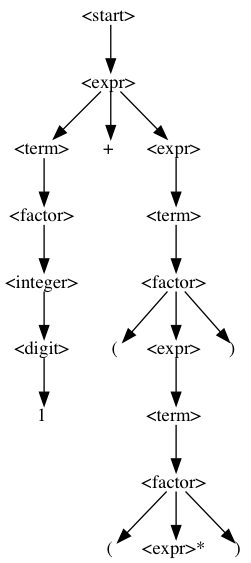

In [86]:
zoom(display_tree(till_abstract(t)))

In [87]:
def Da(t):
    return zoom(display_tree(till_abstract(t)))

In [88]:
abs_t1_ = find_node(expr_tree, [0, 2])
tree_to_str(abs_t1_), abs_t1_[0]

('((2 * 3 / 4))', '<expr>')

In [89]:
abs_t1 = ('<start>', [abs_t1_])

In [90]:
validate_tree(abs_t1, EXPR_GRAMMAR)

In [91]:
t_abs_p1 = [0, 0, 0, 1, 0, 0, 1]
Ts(find_node(abs_t1, t_abs_p1))

'2 * 3 / 4'

We now define a function to check if a given node is abstract or not.

In [92]:
def is_node_abstract(node):
    name, children, *abstract_a = node
    if not abstract_a:
        return True
    else:
        return abstract_a[0]['abstract']

In [93]:
def tree_to_str_a(tree):
    name, children, *general_ = tree
    if not is_nt(name): return name
    if is_node_abstract(tree):
        return name
    return ''.join([tree_to_str_a(c) for c in children])

In [94]:
Ta = tree_to_str_a

In [95]:
tree_to_str_a(t)

'1 + ((<expr>))'

In [96]:
abs_tree1 = mark_concrete_r(mark_path_abstract(abs_t1, t_abs_p1)); abs_tree1

('<start>',
 [('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('(', [], {'abstract': False}),
              ('<expr>',
               [('<term>',
                 [('<factor>',
                   [('<integer>',
                     [('<digit>',
                       [('2', [], {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False})],
                   {'abstract': False}),
                  (' * ', [], {'abstract': False}),
                  ('<term>',
                   [('<factor>',
                     [('<integer>',
                       [('<digit>',
                         [('3', [], {'abstract': False})],
                         {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False}),
                    (' / ', [], {'abstract': False}),
               

In [97]:
Ta(abs_tree1)

'((<expr>))'

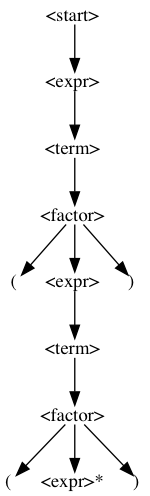

In [98]:
Da(abs_tree1)

In [99]:
def mark_abstract_nodes(tree, paths):
    for path in paths:
        tree = mark_path_abstract(tree, path)
    return mark_concrete_r(tree)

In [100]:
Ta(mark_abstract_nodes(abs_t1, []))

'((2 * 3 / 4))'

In [101]:
Ta(mark_abstract_nodes(abs_t1, [t_abs_p1]))

'((<expr>))'

### Finding characterizing node

A characterizing node is the lowest node that completely contains the given pattern.

In [102]:
 def find_charecterizing_node(tree):
    name, children, gen = tree
    if len(children) == 1:
        return find_charecterizing_node(children[0])
    return tree

In [103]:
abs_tree_cnode1 = find_charecterizing_node(abs_tree1); abs_tree_cnode1

('<factor>',
 [('(', [], {'abstract': False}),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
                     {'abstract'

As can be seen, the `<factor>` node completely contains the fault pattern.

In [104]:
abs_tree1[0], Ts(abs_tree1)

('<start>', '((2 * 3 / 4))')

In [105]:
abs_tree_cnode1[0], Ts(abs_tree_cnode1)

('<factor>', '((2 * 3 / 4))')

### Finding reachable keys

In [106]:
def find_reachable_keys(grammar, key, reachable_keys=None, found_so_far=None):
    if reachable_keys is None: reachable_keys = {}
    if found_so_far is None: found_so_far = set()

    for rule in grammar[key]:
        for token in rule:
            if not is_nt(token): continue
            if token in found_so_far: continue
            found_so_far.add(token)
            if token in reachable_keys:
                for k in reachable_keys[token]:
                    found_so_far.add(k)
            else:
                keys = find_reachable_keys(grammar, token, reachable_keys, found_so_far)
                # reachable_keys[token] = keys <- found_so_far contains results from earlier
    return found_so_far

In [107]:
for key in EXPR_GRAMMAR:
    keys = find_reachable_keys(EXPR_GRAMMAR, key, {})
    print(key, keys)

<start> {'<integer>', '<expr>', '<term>', '<factor>', '<digit>'}
<expr> {'<integer>', '<expr>', '<term>', '<factor>', '<digit>'}
<term> {'<integer>', '<expr>', '<term>', '<factor>', '<digit>'}
<factor> {'<integer>', '<expr>', '<term>', '<factor>', '<digit>'}
<integer> {'<integer>', '<digit>'}
<digit> set()


Finding recursive keys

In [108]:
def reachable_dict(grammar):
    reachable = {}
    for key in grammar:
        keys = find_reachable_keys(grammar, key, reachable)
        reachable[key] = keys
    return reachable

In [109]:
reachable_dict(EXPR_GRAMMAR)

{'<start>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<expr>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<term>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<factor>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<integer>': {'<digit>', '<integer>'},
 '<digit>': set()}

### Updating the grammar with failure keys

Now, we want to add our grammar the keys that are required to cause a failure. For that, we first extract the local grammar that reproduces the fault pattern 

#### Linear Grammar

In [110]:
abs_tree_cnode1

('<factor>',
 [('(', [], {'abstract': False}),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
                     {'abstract'

In [111]:
 def mark_faulty_name(symbol, prefix, v):
    return '<%s L%s_%s>'% (symbol[1:-1], prefix, v)

In [112]:
def mark_faulty_nodes(node, prefix, counter=None):
    if counter is None: counter = {}
    symbol, children, *abstract = node
    if is_node_abstract(node): # we dont markup further
        return node
    if symbol not in counter: counter[symbol] = 0
    counter[symbol] += 1
    v = str(counter[symbol])
    if is_nt(symbol):
        return (mark_faulty_name(symbol, prefix, v),
                [mark_faulty_nodes(c, prefix, counter) for c in children],
                *abstract)
    else:
        assert not children
        return (symbol, children, *abstract)

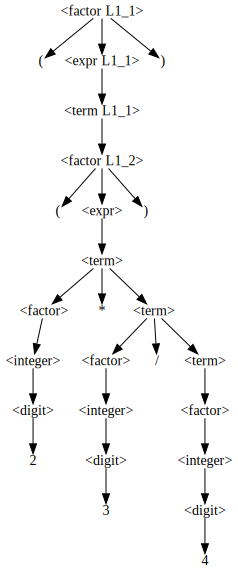

In [113]:
display_tree(mark_faulty_nodes(abs_tree_cnode1, '1'))

In [114]:
c_node1 = mark_faulty_nodes(abs_tree_cnode1, '1')

In [115]:
f_node1 = c_node1

In [116]:
def faulty_node_to_grammar(tree, grammar=None):
    if grammar is None: grammar = {}
    if is_node_abstract(tree): return grammar
    name, children, *rest = tree
    tokens = []
    if name not in grammar: grammar[name] = []
    for c in children:
        n, cs, *rest = c
        tokens.append(n)
        if is_nt(n):
            faulty_node_to_grammar(c, grammar)
    grammar[name].append(tuple(tokens))
    return grammar, tree[0]

In [117]:
g, s = faulty_node_to_grammar(abs_tree_cnode1)
Gs(g)
s

<factor> ::=
|    '(' <expr> ')'
|    '(' <expr> ')'
<expr> ::=
|    <term>
<term> ::=
|    <factor>
3 4


'<factor>'

In [118]:
def faulty_node_to_linear_grammar(tree, prefix, grammar=None):
    ltree = mark_faulty_nodes(tree, prefix)
    return faulty_node_to_grammar(ltree)

In [119]:
lg1, ls1 = faulty_node_to_linear_grammar(abs_tree_cnode1, '1')
Gs(lg1)
ls1

<factor L1_1> ::=
|    '(' <expr L1_1> ')'
<expr L1_1> ::=
|    <term L1_1>
<term L1_1> ::=
|    <factor L1_2>
<factor L1_2> ::=
|    '(' <expr> ')'
4 4


'<factor L1_1>'

In [120]:
dd_tree_abs1 = abs_tree1

In [121]:
node_faulty1 = abs_tree_cnode1

#### Negated linear grammar

Given a linear grammar and the correspoinding grammar, we produce a negated linear grammar for it.

In [122]:
def negate_lkey(key):
    name, pattern = tsplit(key)
    return '<%s -%s>' % (name, pattern)

In [123]:
def negate_key_at(rule, at):
    new_rule = []
    for i,key in enumerate(rule):
        if i == at:
            new_rule.append(negate_lkey(key))
        else:
            new_rule.append(key)
    return new_rule

A node is unrefined (opposite of refined) if it is not refined.

In [124]:
def is_refined(key):
    return (' ' in key)

In [125]:
def negated_linear_grammar(lkey, linear_grammar, base_grammar):
    new_grammar = {}
    for l_key in linear_grammar:
        nl_key = negate_lkey(l_key)
        new_grammar[nl_key] = []
        l_rule = linear_grammar[l_key][0]
        # find all rules that do not match, and add to new_grammar
        for rule in base_grammar[normalize(l_key)]:
            if rule_to_normalized_rule(rule) != rule_to_normalized_rule(l_rule):
                new_grammar[nl_key].append(rule)
        # now negate the rule one token at a time.
        for i, token in enumerate(l_rule):
            if not is_nt(token): continue
            if not is_refined(token): continue
            new_rule = negate_key_at(l_rule, i)
            new_grammar[nl_key].append(new_rule)
    return new_grammar, negate_lkey(lkey) 

In [126]:
lg1

{'<factor L1_1>': [('(', '<expr L1_1>', ')')],
 '<expr L1_1>': [('<term L1_1>',)],
 '<term L1_1>': [('<factor L1_2>',)],
 '<factor L1_2>': [('(', '<expr>', ')')]}

In [127]:
nlg1, nls1 = negated_linear_grammar(ls1, lg1, EXPR_GRAMMAR)
Gs(nlg1)
nls1

<factor -L1_1> ::=
|    '+' <factor>
|    '-' <factor>
|    <integer> '.' <integer>
|    <integer>
|    '(' <expr -L1_1> ')'
<expr -L1_1> ::=
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
|    <term -L1_1>
<term -L1_1> ::=
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
|    <factor -L1_2>
<factor -L1_2> ::=
|    '+' <factor>
|    '-' <factor>
|    <integer> '.' <integer>
|    <integer>
4 15


'<factor -L1_1>'

### Finding insertable positions

Given a rule, and the faulty symbol, the positions in the rule where the fault can be inserted are all the non-terminals that will eventually reach the symbol of the faulty symbol. That is, if we have `<digit> + <expr>` as the expansion and the faulty symbol is `<factor*>` then, since `<digit>` can never reach `<factor>`, `0` is out, and so is `1` since it is a terminal symbol. Hence, only `<expr>` remains, which when expanded, one of the expansion paths will include a `<factor>`. Hence, here `[2]` is the answer.

In [128]:
def get_reachable_positions(rule, fkey, reachable):
    positions = []
    for i, token in enumerate(rule):
        if not is_nt(token): continue
        if fkey in reachable[token]:
            positions.append(i)
    return positions

In [129]:
reachable1 = reachable_dict(EXPR_GRAMMAR)

In [130]:
for k in EXPR_GRAMMAR:
    print(k)
    for rule in EXPR_GRAMMAR[k]:
        v = get_reachable_positions(rule, '<factor>', reachable1)
        print('\t', rule, v)

<start>
	 ['<expr>'] [0]
<expr>
	 ['<term>', ' + ', '<expr>'] [0, 2]
	 ['<term>', ' - ', '<expr>'] [0, 2]
	 ['<term>'] [0]
<term>
	 ['<factor>', ' * ', '<term>'] [0, 2]
	 ['<factor>', ' / ', '<term>'] [0, 2]
	 ['<factor>'] [0]
<factor>
	 ['+', '<factor>'] [1]
	 ['-', '<factor>'] [1]
	 ['(', '<expr>', ')'] [1]
	 ['<integer>', '.', '<integer>'] []
	 ['<integer>'] []
<integer>
	 ['<digit>', '<integer>'] []
	 ['<digit>'] []
<digit>
	 ['0'] []
	 ['1'] []
	 ['2'] []
	 ['3'] []
	 ['4'] []
	 ['5'] []
	 ['6'] []
	 ['7'] []
	 ['8'] []
	 ['9'] []


### Insert into key definition

The essential idea is to make the rules in the grammar such that there is one fault position in each position.
Take one rule at a time. For each token in the rule, get the reachable tokens. If the fsym is not in reachable tokens, then the falt cannot be inserted in that position. So get all positions for the rule that we can insert fsym in, and for each position, change the symbol for later insertion.

In [131]:
from enum import Enum

In [132]:
class FKey(str, Enum):
    negate = 'NEGATE'
    fault = 'FAULT'
    atmost = 'ATMOST'
    atleast = 'ATLEAST'
    exactly = 'EXACTLY'

In [133]:
def to_fkey_prefix(name, prefix, kind):
    if kind == FKey.negate:
        return "<%s -F%s>" % (name[1:-1], prefix)
    elif kind == FKey.fault:
        return "<%s .F%s>" % (name[1:-1], prefix)
    elif kind == FKey.atmost:
        return "<%s *F%s>" % (name[1:-1], prefix)
    elif kind == FKey.atleast:
        return "<%s +F%s>" % (name[1:-1], prefix)
    elif kind == FKey.exactly:
        return "<%s F%s>" % (name[1:-1], prefix)
    assert False

In [134]:
def insert_into_key(grammar, key, fsym, prefix, reachable):
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = get_reachable_positions(rule, fsym, reachable)
        if not positions: # make it len(positions) >= n if necessary
            # skip this rule because we can not embed the fault here.
            continue
        else:
            # at each position, insert the fsym
            for pos in positions:
                new_rule = [to_fkey_prefix(t, prefix, FKey.fault)
                            if pos == p else t for p,t in enumerate(rule)]
                my_rules.append(new_rule)
    return (to_fkey_prefix(key, prefix, FKey.fault), my_rules)

In [135]:
for key in EXPR_GRAMMAR:
    fk, rules = insert_into_key(EXPR_GRAMMAR, key, '<factor>', '1', reachable1)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start .F1>
     ['<expr .F1>']

<expr .F1>
     ['<term .F1>', ' + ', '<expr>']
     ['<term>', ' + ', '<expr .F1>']
     ['<term .F1>', ' - ', '<expr>']
     ['<term>', ' - ', '<expr .F1>']
     ['<term .F1>']

<term .F1>
     ['<factor .F1>', ' * ', '<term>']
     ['<factor>', ' * ', '<term .F1>']
     ['<factor .F1>', ' / ', '<term>']
     ['<factor>', ' / ', '<term .F1>']
     ['<factor .F1>']

<factor .F1>
     ['+', '<factor .F1>']
     ['-', '<factor .F1>']
     ['(', '<expr .F1>', ')']

<integer .F1>

<digit .F1>



In [136]:
def insert_into_grammar(grammar, fsym, prefix_f, reachable):
    new_grammar = {}
    for key in grammar:
        fk, rules = insert_into_key(grammar, key, fsym, prefix_f, reachable)
        if not rules: continue # no applicable rules
        if fk not in new_grammar:
            new_grammar[fk] = []
        new_grammar[fk].extend(rules)
    return new_grammar

### Get the final grammar

The final steps are as follows:
1. Add the fault node, and the child nodes to the grammar.
2. Generate the faulty key definitions. This is done per key in the original grammar.
3. Finally, connect the faulty key and fault node.

In [137]:
def atleast_one_fault_grammar(grammar, start_symbol, fault_node, f_idx):
    def L_prefix(i): return str(i)
    def F_prefix(i): return str(i)
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    # First, get the linear grammar

    g0, fkey = faulty_node_to_linear_grammar(fault_node, prefix_l)
 
    reachable = reachable_dict(grammar)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    g1 = insert_into_grammar(grammar, key_f, prefix_f, reachable)

    # now, the faulty key is an alternative to the original.
    # We have to take care of one thing though. The `fkey` in the linear grammar should
    # be replaced with fsym, but the definitions kept. This is because we want to preserve
    # the rule patterns. We do not want normal expansions to go through since it may mean
    # no fault inserted. However, we want self recursion to happen.
    fsym = to_fkey_prefix(key_f, prefix_f, FKey.fault)

    new_grammar = {**grammar, **g0, **g1}
    new_rules = g0[fkey] # get the linear rule
    
    for rule in new_grammar[fsym]:
        for token in rule:
            if not is_nt(token): continue
            if normalize(token) == key_f:
                new_rules.append(rule) # self recursion. We want to keep this
                break
 
    new_grammar[fsym] = new_rules

    return new_grammar, to_fkey_prefix(start_symbol, F_prefix(f_idx), FKey.fault)

In [138]:
node_faulty1[0]

'<factor>'

The guarantee is at least one fault per input.

In [139]:
faulty1_grammar_, faulty1_start = atleast_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, node_faulty1, 1)
Gs(faulty1_grammar_, -1)

14 44


In [140]:
faulty1_grammar, faulty1_start = grammar_gc(faulty1_grammar_, faulty1_start)
Gs(faulty1_grammar)
faulty1_start

<start .F1> ::=
|    <expr .F1>
<expr .F1> ::=
|    <term> ' + ' <expr .F1>
|    <term .F1> ' + ' <expr>
|    <term> ' - ' <expr .F1>
|    <term .F1>
|    <term .F1> ' - ' <expr>
<term .F1> ::=
|    <factor .F1> ' / ' <term>
|    <factor .F1> ' * ' <term>
|    <factor> ' / ' <term .F1>
|    <factor> ' * ' <term .F1>
|    <factor .F1>
<expr> ::=
|    <term> ' + ' <expr>
|    <term>
|    <term> ' - ' <expr>
<term> ::=
|    <factor> ' / ' <term>
|    <factor> ' * ' <term>
|    <factor>
<factor .F1> ::=
|    '+' <factor .F1>
|    '(' <expr L1_1> ')'
|    '-' <factor .F1>
<factor> ::=
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
|    '(' <expr> ')'
|    '+' <factor>
<expr L1_1> ::=
|    <term L1_1>
<term L1_1> ::=
|    <factor L1_2>
<factor L1_2> ::=
|    '(' <expr> ')'
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '4'
|    '6'
|    '1'
|    '5'
|    '7'
|    '0'
|    '8'
|    '3'
|    '2'
|    '9'
12 40


'<start .F1>'

In [141]:
faulty1_fuzzer = LimitFuzzer(faulty1_grammar)
faulty1_parser = Parser(faulty1_grammar, canonical=True, start_symbol=faulty1_start)

In [142]:
for i in range(10):
    s = faulty1_fuzzer.fuzz(key=faulty1_start)
    print(s)
    for t in faulty1_parser.parse(s):
        assert tree_to_str(t) == s

((-7.4 * 6 + 2.3 * 4.5)) - +1 / -++--3 + 5.851 - -++-3.5 * 290 * (2.5 - 9.3) * 8 * 5.4 - 5
-((2 * 0)) - ((8.4 / 1.8 + 6.1 + 9) / 68.00) / -8.1 * 1.3 / +(8.6 - 3.6) / 9 / 0.8 - -(7.3 * 6.4 / 6 + 4 / 4 - 5.2 + 2) + (1 * 1 * 3.2) + 2 + +-2.3 / (3.4) * 6 / 5.7 - +2.6 / 2
36 / 0 / --(7.2 - 9 + 8.5) * --(9.5 + 7) + ---+++((7.3)) - +-(9 * 6.8) / (-1 - 3 * 5.5 + 9 + 1.3) / 92.4 * 84 - 93.91 - 9.0
59 - ---((0.4))
+-++((7)) * 9.5 * (+-0.5 / 7.5 + 6.3 / 8) / ++(9 + 2.1) / -+1.4
((+5 / 2 / 5 - 0.9 * 8.5 - 6 + 5.2)) * +(23.48 / 5 + 0.9 - 2.0 / 6.5)
--(3.90 / 4.1 * 9.6 / 1 - -2.7) / 85.0 * ---+((9.6))
7.9 * ((3 - 7.0 + 5.5) / -2.4 * +9.7 * 1.2 + (2.3 - 0) / +6 / 6.6 / 1 - -8) / -+-+9 / +-5.6 * -(6.6) / -7.1 * 2.8 * 9.5 / 1.9 + -+---((9)) - +2 / 03 / ++(4.3) * -(7) + 6 / 7 / +8.3 / -1.9 + (8.7 * 2 - 6 - 6) * 46.5 * (5) / 8.2 * 9
-++(-7 * 4 / 4.2 - 7.2 * 7) + +--+(4 - 7) / 5 / +((0.1)) / +(7 + 4.8) * 3.6 - 90.0 * -5 / 77.399 - +-3 / 4 * 3 + -(1.0 - 0) / 93.3 * +3.6 - 48.82 * (3)
5405 * 05623 * +((2.6)

A few parses

In [143]:
for tree in faulty1_parser.parse('((2))'):
    print(tree_to_str(tree))

((2))


In [144]:
for tree in faulty1_parser.parse('((1 + 1))'):
    print(tree_to_str(tree))

((1 + 1))


In [145]:
try:
    for tree in faulty1_parser.parse('1 + 2'):
        print(tree)
except SyntaxError as e:
    print(e)

at '1 + 2'


In [146]:
for tree in faulty1_parser.parse('1 + ((3))'):
    print(tree_to_str(tree))

1 + ((3))


## Removing a fault

The question is, given a grammar, how do we make sure that a particular abstract pattern does not occur. 

### Remove from key

We need to define the `remove_from_key` first. The idea is that the fault does not occur in any of the reachable nonterminals.

In [147]:
def remove_from_key(grammar, key, fsym, prefix, reachable):
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = get_reachable_positions(rule, fsym, reachable)
        if not positions: # make it len(positions) >= n if necessary
            # add this rule as is because we cannot embed the fault here.
            my_rules.append(rule)
        else:
            # at each position, insert the fsym
            new_rule = []
            for pos, token in enumerate(rule):
                t = to_fkey_prefix(rule[pos], prefix, FKey.negate) if pos in positions else token
                new_rule.append(t)
            my_rules.append(new_rule)
    return (to_fkey_prefix(key, prefix, FKey.negate), my_rules)

In [148]:
for key in EXPR_GRAMMAR:
    fk, rules = remove_from_key(EXPR_GRAMMAR, key, '<factor>', '1', reachable1)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start -F1>
     ['<expr -F1>']

<expr -F1>
     ['<term -F1>', ' + ', '<expr -F1>']
     ['<term -F1>', ' - ', '<expr -F1>']
     ['<term -F1>']

<term -F1>
     ['<factor -F1>', ' * ', '<term -F1>']
     ['<factor -F1>', ' / ', '<term -F1>']
     ['<factor -F1>']

<factor -F1>
     ['+', '<factor -F1>']
     ['-', '<factor -F1>']
     ['(', '<expr -F1>', ')']
     ['<integer>', '.', '<integer>']
     ['<integer>']

<integer -F1>
     ['<digit>', '<integer>']
     ['<digit>']

<digit -F1>
     ['0']
     ['1']
     ['2']
     ['3']
     ['4']
     ['5']
     ['6']
     ['7']
     ['8']
     ['9']



### Remove from grammar

In [149]:
def remove_from_grammar(grammar, fsym, prefix_f, reachable):
    new_grammar = {}
    for key in grammar:
        fk, rules = remove_from_key(grammar, key, fsym, prefix_f, reachable)
        if not rules: continue # no applicable rules
        if fk not in new_grammar:
            new_grammar[fk] = []
        new_grammar[fk].extend(rules)
    return new_grammar

### Get the final grammar

The final steps are as follows:
1. Add the fault node, and the child nodes to the grammar.
2. Generate the faulty key definitions. This is done per key in the original grammar.
3. Finally, connect the faulty key and fault node.

In [150]:
def no_fault_grammar(grammar, start_symbol, fault_node, f_idx):
    def L_prefix(i): return str(i)
    def F_prefix(i): return str(i)
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    # First, get the linear grammar

    g0, fkey0 = faulty_node_to_linear_grammar(fault_node, prefix_l)
    g1, fkey1 = negated_linear_grammar(fkey0, g0, grammar)
 
    reachable = reachable_dict(grammar)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    g2 = remove_from_grammar(grammar, key_f, prefix_f, reachable)

    # now, the faulty key is an alternative to the original.
    # We have to take care of one thing though. The `fkey` in the linear grammar should
    # be replaced with fsym, but the definitions kept. This is because we want to preserve
    # the rule patterns. We do not want normal expansions to go through since it may mean
    # no fault inserted. However, we want self recursion to happen.
    fsym = to_fkey_prefix(key_f, prefix_f, FKey.negate)

    new_grammar = {**grammar, **g1, **g2}
    new_rules = g1[fkey1] # get the linear rule
    
    for rule in new_grammar[fsym]:
        for token in rule:
            if not is_nt(token): continue
            if normalize(token) == key_f:
                new_rules.append(rule) # self recursion. We want to keep this
                break
 
    new_grammar[fsym] = new_rules

    return new_grammar, to_fkey_prefix(start_symbol, F_prefix(f_idx), FKey.negate)

In [151]:
node_faulty1[0]

'<factor>'

In [152]:
nfaulty1_grammar_, nfaulty1_start = no_fault_grammar(EXPR_GRAMMAR, EXPR_START, node_faulty1, 1)
Gs(nfaulty1_grammar_, -1)
nfaulty1_grammar, nfaulty1_start = grammar_gc(nfaulty1_grammar_, nfaulty1_start)
Gs(nfaulty1_grammar)
nfaulty1_start

16 67
<start -F1> ::=
|    <expr -F1>
<expr -F1> ::=
|    <term -F1> ' - ' <expr -F1>
|    <term -F1>
|    <term -F1> ' + ' <expr -F1>
<term -F1> ::=
|    <factor -F1> ' * ' <term -F1>
|    <factor -F1>
|    <factor -F1> ' / ' <term -F1>
<factor -F1> ::=
|    '(' <expr -L1_1> ')'
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
|    '+' <factor>
<expr -L1_1> ::=
|    <term> ' + ' <expr>
|    <term -L1_1>
|    <term> ' - ' <expr>
<factor> ::=
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
|    '(' <expr> ')'
|    '+' <factor>
<integer> ::=
|    <digit>
|    <digit> <integer>
<term -L1_1> ::=
|    <factor> ' / ' <term>
|    <factor> ' * ' <term>
|    <factor -L1_2>
<term> ::=
|    <factor> ' / ' <term>
|    <factor> ' * ' <term>
|    <factor>
<expr> ::=
|    <term> ' + ' <expr>
|    <term>
|    <term> ' - ' <expr>
<factor -L1_2> ::=
|    '+' <factor>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
<digit> ::=
|    '4'
|    '6'
|    '1'
|    '5'
|

'<start -F1>'

In [153]:
nfaulty1_fuzzer = LimitFuzzer(nfaulty1_grammar)
nfaulty1_parser = Parser(nfaulty1_grammar, canonical=True, start_symbol=nfaulty1_start)

In [154]:
for i in range(10):
    s = nfaulty1_fuzzer.fuzz(key=nfaulty1_start)
    print(s)
    for t in nfaulty1_parser.parse(s):
        assert tree_to_str(t) == s

-+(91.0) * +5.98 * (3 * 6 * 8.7 - 9.8) / +---4.8 * +(4 + 2.7) + 548 * (-(0.5)) * 2
+781 - 711
1
((5.1 * 9 - 2.3 / 0) * +7 * 67 / 9) + +(19.92 * 1.0 * 0 * 4.0) / --(4.2)
1.64 * -+301 + -+3212 / (75 + -5) * (+5) * (8 / 4 - 5.6 - 2.8) + -3 + -004 / -(8 - 6.0) * 6.4 / (8.8) * 6.7 / 9 - (0 + 3) * 9 / 4 / 8 * 7.4
49.0122 / 724876.5 / (+-0.4 - 6 / 9 * 5.3) / (9 * 4 / 0 + 5.6 / 8 + 4.2 - 9) * (0) / 41 / +8 * 6
+-1.3 / 9 / (76.56 - (1) * 3.7)
(((5) * 3.8 * 3.5 + 1 / 8.1) * (4 / 1 - 5.2) * (6.1 + 9.1) * +1 * 4.0 / 0 + 725.51 * (8) / 4.7 / 3 / 1.4 + (7.6 + 2) - -9.4 / 2.2 / 2 + 7 / 9 + 8 + 4) + 6.13 / --(3.4 + 3 + 3) * ++(4 - 0.2) / -93 / (4 - 0.0) / (5.4) * 4.1 / 9.6
94398.74 * (-(1) * 44 + 98.85 * +6.4 * 4 + 6 + 1.5 + 8) / 23345.08993 + -+-722.22 * 956.5 - -27 - ((5.2) - 0 / 0 - 1.2 + 7) * 490 * 42 * +5 / 4.4
--+-(6.4 * 1 + 7.6 + 2.6) * 069.63 / (--3.7 / (1)) + 57.08 / (4.47 / 6.8 * 1.1 / 9) / 2 * 2 * 91 / -1 - +(2 / 4 * 1 + 2) + +-6


A few parses

In [155]:
try:
    for tree in nfaulty1_parser.parse('((2))'):
        print(tree_to_str(tree))
except SyntaxError as e:
     print(e)

at '((2))'


In [156]:
try:
    for tree in nfaulty1_parser.parse('((1 + 1))'):
        print(tree_to_str(tree))
except SyntaxError as e:
    print(e)

at '((1 + 1))'


In [157]:
for tree in nfaulty1_parser.parse('1 + 2'):
    print(tree)

('<start -F1>', [('<expr -F1>', [('<term -F1>', [('<factor -F1>', [('<integer>', [('<digit>', [('1', [])])])])]), (' + ', []), ('<expr -F1>', [('<term -F1>', [('<factor -F1>', [('<integer>', [('<digit>', [('2', [])])])])])])])])


In [158]:
try:
    for tree in nfaulty1_parser.parse('1 + ((3))'):
        print(tree_to_str(tree))
except SyntaxError as e:
    print(e)

at ' + ((3))'


## At most one fault

### Remove except one from key

In [159]:
def remove_except_one_from_key(grammar, key, fsym, prefix, reachable):
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = get_reachable_positions(rule, fsym, reachable)
        if not positions: # make it len(positions) >= n if necessary
            # add this rule as is because we can not embed the fault here.
            my_rules.append(rule)
        else:
            # skip pos for each rule
            for pos in positions:
                new_rule = []
                for p,token in enumerate(rule):
                    if (p in positions):
                        if (p != pos): # at p position, there _may be_ a fault, but not in other places
                            new_rule.append(to_fkey_prefix(rule[p], prefix, FKey.negate))
                        else:
                            # change to FKey.exactly to make it exactly
                            new_rule.append(to_fkey_prefix(rule[p], prefix, FKey.atmost))
                    else:
                        new_rule.append(token)
                my_rules.append(new_rule)
    return (to_fkey_prefix(key, prefix, FKey.atmost), my_rules)

### Remove except one from grammar

In [160]:
def remove_except_one_from_grammar(grammar, fsym, prefix_f, reachable):
    new_grammar = {}
    for key in grammar:
        fk, rules = remove_except_one_from_key(grammar, key, fsym, prefix_f, reachable)
        if not rules: continue # no applicable rules
        if fk not in new_grammar:
            new_grammar[fk] = []
        new_grammar[fk].extend(rules)
    return new_grammar

### Atmost one fault grammar

In [161]:
def atmost_one_fault_grammar(grammar, start_symbol, fault_node, f_idx):
    def L_prefix(i): return str(i)
    def F_prefix(i): return str(i)
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    # First, get the linear grammar

    g1, fkey1  = faulty_node_to_linear_grammar(fault_node, prefix_l)
    g2, fkey2  = negated_linear_grammar(fkey1, g1, grammar)

    reachable = reachable_dict(grammar)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    g3 = remove_except_one_from_grammar(grammar, key_f, prefix_f, reachable)

    g4 = remove_from_grammar(grammar, key_f, prefix_f, reachable)
    
    # now, the faulty key is an alternative to the original.
    # We have to take care of one thing though. The `fkey` in the linear grammar should
    # be replaced with fsym, but the definitions kept. This is because we want to preserve
    # the rule patterns. We do not want normal expansions to go through since it may mean
    # no fault inserted. However, we want self recursion to happen.
    fsym = to_fkey_prefix(key_f, prefix_f, FKey.negate)

    new_grammar = {**grammar, **g1, **g2, **g3, **g4}
    new_rules = g2[fkey2] # get the linear rule
    
    for rule in new_grammar[fsym]:
        for token in rule:
            if not is_nt(token): continue
            if normalize(token) == key_f:
                new_rules.append(rule) # self recursion. We want to keep this
                break
    new_grammar[fsym] = new_rules
    
    # todo; we also want to insert the negative 

    return new_grammar, to_fkey_prefix(start_symbol, F_prefix(f_idx), FKey.atmost)

In [162]:
nfaultya1_grammar_, nfaultya1_start = atmost_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, node_faulty1, 1)
Gs(nfaultya1_grammar_, -1)
nfaultya1_grammar, nfaultya1_start = grammar_gc(nfaultya1_grammar_, nfaultya1_start)
Gs(nfaultya1_grammar)
nfaultya1_start

26 99
<start *F1> ::=
|    <expr *F1>
<expr *F1> ::=
|    <term *F1> ' + ' <expr -F1>
|    <term *F1>
|    <term -F1> ' - ' <expr *F1>
|    <term *F1> ' - ' <expr -F1>
|    <term -F1> ' + ' <expr *F1>
<term *F1> ::=
|    <factor *F1> ' * ' <term -F1>
|    <factor -F1> ' / ' <term *F1>
|    <factor *F1> ' / ' <term -F1>
|    <factor *F1>
|    <factor -F1> ' * ' <term *F1>
<expr -F1> ::=
|    <term -F1> ' - ' <expr -F1>
|    <term -F1>
|    <term -F1> ' + ' <expr -F1>
<term -F1> ::=
|    <factor -F1> ' * ' <term -F1>
|    <factor -F1>
|    <factor -F1> ' / ' <term -F1>
<factor *F1> ::=
|    '(' <expr *F1> ')'
|    <integer>
|    <integer> '.' <integer>
|    '-' <factor *F1>
|    '+' <factor *F1>
<factor -F1> ::=
|    '(' <expr -L1_1> ')'
|    '+' <factor -F1>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
|    '-' <factor -F1>
|    '+' <factor>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '4'
|    '6'
|    '1'
|    '5'
|    '7'
|    '0'
|    '8'
|    

'<start *F1>'

In [163]:
nfaultya1_fuzzer = LimitFuzzer(nfaultya1_grammar)
nfaultya1_parser = Parser(nfaultya1_grammar, canonical=True, start_symbol=nfaultya1_start)

In [164]:
for i in range(10):
    s = nfaultya1_fuzzer.fuzz(key=nfaultya1_start)
    print(s)
    for t in nfaultya1_parser.parse(s):
        assert tree_to_str(t) == s

+-38 + 1.0 + 8
444.8 / 843.3
5 - -5.24 / (-4 / -2) / 09 * (9.5 - 7.2 - 7) * +(6) * -9.6
52037.1 - 4 + ---+(3) / (-7.7) - (+5) / 866 * --4 - +0.48 + 99 / -4 - +0 * 5 / 9.9 - 4.2 * 1.3
+-++(3.9 * 4 + 0.7 - 3.7) * 6.4 + 87.8 / 38.61 * +4 * ++1 * 16.60 / 7.8 * 7 / 3
1402666 / -1805 / +-4.61 / 6.232 / (3 / 4 + 7) * (1.7 + 4.0) / 9.5 * 5.8 / 7 - ++-(0.9 * 1.1) / -8 * +0 / -+(1.9) * +-5
+2.6181 * +-20.5 * --(7 * 7.2 + 1.1 - 1) / +8.4 + 0.9 * +-95 / +0.06 / 25
8.759720 * +2 * +9444.4351 * 194.35 / +4 * (4) + ++(+4 * 3 * 2 + 7 * 4 - 5.7 - 4) / 8306.9 / 6486 + +77.025 / (-0.8 / 9.6 / 0.2 - 3 / 1.7 - 1.3 + 8.1) + +(8 / 4.8) * -29 * -(4.1) - --9 * 45.6 + +(1.3) * +2 / 9.9 / 6 - (4.5) - 1
+(9.1 - -(0.0) * 5.3 / 6.6 - (6) - 9 * 7.6) / (6 / --6 + +2.1 * +8.0 * 4.1 - (8)) / +++(4.5) * -3 + --+89.5 * 4.8 / -+--3 / 0.364
++--(3) / +((0 - 2) + 8 / 1.4 - 6 / 6) / +5 / -3 / +46.2 * (8 - 9.2) / 9 + -91 / ((4.5 + 9.3) * -2.2 / 1.7 * 3.4 + 1 / 2 * 4.3 - 5.8 - 5.3 - 3.6) / 68 * -++0 * +2 * +5.7 * 6.1 * 0.4 + -

A few parses

In [165]:
try:
    for tree in nfaultya1_parser.parse('((2))'):
        print(tree_to_str(tree))
except SyntaxError as e:
     print(e)

((2))


In [166]:
try:
    for tree in nfaultya1_parser.parse('((1 + 1))'):
        print(tree_to_str(tree))
except SyntaxError as e:
    print(e)

((1 + 1))


In [167]:
for tree in nfaultya1_parser.parse('1 + 2'):
    print(tree)

('<start *F1>', [('<expr *F1>', [('<term *F1>', [('<factor *F1>', [('<integer>', [('<digit>', [('1', [])])])])]), (' + ', []), ('<expr -F1>', [('<term -F1>', [('<factor -F1>', [('<integer>', [('<digit>', [('2', [])])])])])])])])
('<start *F1>', [('<expr *F1>', [('<term -F1>', [('<factor -F1>', [('<integer>', [('<digit>', [('1', [])])])])]), (' + ', []), ('<expr *F1>', [('<term *F1>', [('<factor *F1>', [('<integer>', [('<digit>', [('2', [])])])])])])])])


In [168]:
try:
    for tree in nfaultya1_parser.parse('1 + ((3))'):
        print(tree_to_str(tree))
except SyntaxError as e:
    print(e)

1 + ((3))


## Exactly one fault grammar

In [169]:
def keep_exactly_one_at_key(grammar, key, fsym, prefix, reachable):
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = get_reachable_positions(rule, fsym, reachable)
        if not positions: # make it len(positions) >= n if necessary
            # add this rule as is because we can not embed the fault here.
            # my_rules.append(rule)
            continue
        else:
            # skip pos for each rule
            for pos in positions:
                new_rule = []
                for p,token in enumerate(rule):
                    if (p in positions):
                        if (p != pos): # at p position, there _should be_ a fault, but not in other places
                            new_rule.append(to_fkey_prefix(rule[p], prefix, FKey.negate))
                        else:
                            new_rule.append(to_fkey_prefix(rule[p], prefix, FKey.exactly))
                    else:
                        new_rule.append(token)
                my_rules.append(new_rule)
    return (to_fkey_prefix(key, prefix, FKey.exactly), my_rules)

In [170]:
def keep_exactly_one_at_grammar(grammar, fsym, prefix_f, reachable):
    new_grammar = {}
    for key in grammar:
        fk, rules = keep_exactly_one_at_key(grammar, key, fsym, prefix_f, reachable)
        if not rules: continue # no applicable rules
        if fk not in new_grammar:
            new_grammar[fk] = []
        new_grammar[fk].extend(rules)
    return new_grammar

In [171]:
def exactly_one_fault_grammar(grammar, start_symbol, fault_node, f_idx, log=False):
    def L_prefix(i): return str(i)
    def F_prefix(i): return str(i)
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    # First, get the linear grammar

    g1, fkey1  = faulty_node_to_linear_grammar(fault_node, prefix_l)
    g2, fkey2  = negated_linear_grammar(fkey1, g1, grammar)

    reachable = reachable_dict(grammar)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    g3 = keep_exactly_one_at_grammar(grammar, key_f, prefix_f, reachable)

    g4 = remove_from_grammar(grammar, key_f, prefix_f, reachable)
    
    # now, the faulty key is an alternative to the original.
    # We have to take care of one thing though. The `fkey` in the linear grammar should
    # be replaced with fsym, but the definitions kept. This is because we want to preserve
    # the rule patterns. We do not want normal expansions to go through since it may mean
    # no fault inserted. However, we _may_ want self recursion to happen.
    # This is however, a tradeoff. If self recursions happen, then we need to make sure that
    # the self recursion does not match the fault immediately.
    fsym = to_fkey_prefix(key_f, prefix_f, FKey.exactly)
    if log: print('Characterizing Node:', fsym)

    new_grammar = {**grammar, **g1, **g2, **g3, **g4}
    if log: print('Replacing Key:', fkey1)
    new_rules = g1[fkey1] # get the linear rule
    
    for rule in new_grammar[fsym]:
        # skip if the rule matches initial expansion of linear grammar
        # TODO: this should actually be allowed so long as we split this rule
        # into multiple rules, and at each point negate the linear grammar.
        # Note, this is the base grammar. So, rule is already normalized.
        fnode_children = fault_node[1]
        if rule == node_to_normalized_rule(fnode_children):
            new_rule = []
            for p,token in enumerate(rule):
                # only negate token p
                if (p != pos): # at p position, there _should be_ a fault, but not in other places
                    new_rule.append(to_fkey_prefix(fnode_children[p][0], prefix_l, FKey.negate))
                else:
                    new_rule.append(token)
                my_rules.append(new_rule)

            continue
        for token in rule:
            if not is_nt(token): continue
            if normalize(token) == key_f:
                # self recursion. We want to keep this,
                new_rules.append(rule)
                break
    new_grammar[fsym] = new_rules
    
    # todo; we also want to insert the negative 

    return new_grammar, to_fkey_prefix(start_symbol, F_prefix(f_idx), FKey.exactly)

In [172]:
efaultya1_grammar_, efaultya1_start = exactly_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, node_faulty1, 1)
Gs(efaultya1_grammar_, -1)
efaultya1_grammar, efaultya1_start = grammar_gc(efaultya1_grammar_, efaultya1_start)
Gs(efaultya1_grammar)
efaultya1_start

24 83
<start F1> ::=
|    <expr F1>
<expr F1> ::=
|    <term F1>
|    <term -F1> ' + ' <expr F1>
|    <term F1> ' - ' <expr -F1>
|    <term F1> ' + ' <expr -F1>
|    <term -F1> ' - ' <expr F1>
<term -F1> ::=
|    <factor -F1> ' * ' <term -F1>
|    <factor -F1>
|    <factor -F1> ' / ' <term -F1>
<term F1> ::=
|    <factor F1>
|    <factor -F1> ' * ' <term F1>
|    <factor F1> ' / ' <term -F1>
|    <factor -F1> ' / ' <term F1>
|    <factor F1> ' * ' <term -F1>
<expr -F1> ::=
|    <term -F1> ' - ' <expr -F1>
|    <term -F1>
|    <term -F1> ' + ' <expr -F1>
<factor -F1> ::=
|    '(' <expr -F1> ')'
|    '+' <factor -F1>
|    <integer>
|    <integer> '.' <integer>
|    '-' <factor -F1>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '4'
|    '6'
|    '1'
|    '5'
|    '7'
|    '0'
|    '8'
|    '3'
|    '2'
|    '9'
<factor F1> ::=
|    '+' <factor F1>
|    '(' <expr L1_1> ')'
|    '-' <factor F1>
<expr L1_1> ::=
|    <term L1_1>
<term L1_1> ::=
|    <factor L1_2>
<factor 

'<start F1>'

In [173]:
efaultya1_fuzzer = LimitFuzzer(efaultya1_grammar)
efaultya1_parser = Parser(efaultya1_grammar, canonical=True, start_symbol=efaultya1_start)

In [174]:
for i in range(10):
    s = efaultya1_fuzzer.fuzz(key=efaultya1_start)
    print(s)
    for t in efaultya1_parser.parse(s):
        assert tree_to_str(t) == s

(80.6 / 5.9) + 76 * (01 / (2.6 + 9) * 8) * -+-((9.7))
(3.0 - -+-0.3 * +8.1 / +1 - 62.8 + +7 * 0 + 6.9 * 4.6 - 8.1) + ++((4.9)) + (9 + +3 / 9 / 5 + 7 + 1 - 6 + 1.7 + 1 + 4.7) * +06.6 + (8.2 / 0.8 + 8.4 / 8.5 + 6) / 01 - (2.2 + 1.4) / -4.6 / 3 / 7.6 - (5 + 7.3 + 9 - 6) + 3.6 * 2.5 / 7.4 - 7
+(-56.39 / 6 + (6 + 6) * -9.2 / 1.9 * 4.2) / (92 * +7.7 - -8) + (4.197 / -0.2 * -4 * 7.0 * 0.4 - 6 * (7.8) / 7.8 / 5) * ((6.5) / (6) / 2 * 5) + -((9)) * 2 / -(1) * ++3.2 * -4 / 7 * 4 + --4
---((2.5)) - 9 + +9.38 * 382.9 * +(2)
-(-+4.7 * --5 - +(3.1 - 2.4 + 1.1 - 9.8 - 3 + 5.3 - 9.3 + 7 - 7 + 2.8) - 0.4 * 2.5 + 2) * 35.766 - (+--0 / 3.2 / (7 + 5.4) - 79.27 * (7 - 5) / 9.1 * 2.6 + +7.1 * 6.7 - 1.3) * ((4 + 1.4)) * -(1.2 * 6) / 260.27 * 33 * +0 + 02.40339 - (-6.8 * 6 * 5.2)
-+--+((6.4)) / 49.5 * --63.66
-(46.8 + ++5.3 * 3.7 - 8.5 - 9.8 / 6.1 + 1.1) - ((2.4 * 0.7 - 5)) + 5.0
(-97.9 * 0 * 39 - (1.7 - 0 - 3.7) - 26.7 * -7 / 3.4 / 6) / -7.55 + 020916.66087 * 0416.4 * -+--((2.1)) / ++9 * +(1.6) / +5.8 / 6 * 1

## Conjunction 

### Exactly one fault

In [175]:
import itertools as I

In [176]:
def conj(k1, k2, simplify=False):
    if is_nt(k1):
        if not simplify:
            return '<%s and(%s,%s)>' % (stem(k1), refinement(k1), refinement(k2))
        
        if refinement(k1) == refinement(k2):
            return k1
        elif not refinement(k1):
            return k2
        elif not  refinement(k2):
            return k1
        else:
            return '<%s and(%s,%s)>' % (stem(k1), refinement(k1), refinement(k2))
    else:
        assert k1 == k2, 'k1: %s k2: %s' % (k1, k2)
        return k1

In [177]:
def and_grammars(g1, s1, g2, s2):
    g1_keys = g1.keys()
    g2_keys = g2.keys()
    g = {}
    # now get the matching keys for each pair.
    for k1,k2 in I.product(g1_keys, g2_keys):
        # define and(k1, k2)
        if normalize(k1) != normalize(k2): continue
        # find matching rules
        new_key_suffix = conj(k1, k2) 
        new_rules = []
        for rule1 in g1[k1]:
            for rule2 in g2[k2]:
                if rule_to_normalized_rule(rule1) != rule_to_normalized_rule(rule2): continue
                new_rule = [conj(t1, t2) for t1,t2 in zip(rule1, rule2)]
                new_rules.append(new_rule) 
        g[new_key_suffix] = new_rules
    return g, conj(s1, s2)

In [178]:
and1_grammar_, and1_start = and_grammars(faulty1_grammar, faulty1_start, nfaultya1_grammar, nfaultya1_start)
Gs(and1_grammar_, -1)
and1_grammar, and1_start = grammar_gc(and1_grammar_, and1_start)
Gs(and1_grammar)
and1_start

39 134
<start and(.F1,*F1)> ::=
|    <expr and(.F1,*F1)>
<expr and(.F1,*F1)> ::=
|    <term and(.F1,*F1)>
|    <term and(,-F1)> ' + ' <expr and(.F1,*F1)>
|    <term and(.F1,*F1)> ' + ' <expr and(,-F1)>
|    <term and(,-F1)> ' - ' <expr and(.F1,*F1)>
|    <term and(.F1,*F1)> ' - ' <expr and(,-F1)>
|    <term and(,*F1)> ' - ' <expr and(.F1,-F1)>
|    <term and(.F1,-F1)> ' + ' <expr and(,*F1)>
|    <term and(,*F1)> ' + ' <expr and(.F1,-F1)>
|    <term and(.F1,-F1)> ' - ' <expr and(,*F1)>
<term and(,*F1)> ::=
|    <factor and(,-F1)> ' * ' <term and(,*F1)>
|    <factor and(,-F1)> ' / ' <term and(,*F1)>
|    <factor and(,*F1)> ' * ' <term and(,-F1)>
|    <factor and(,*F1)> ' / ' <term and(,-F1)>
|    <factor and(,*F1)>
<expr and(.F1,-F1)> ::=
|    <term and(.F1,-F1)> ' + ' <expr and(,-F1)>
|    <term and(,-F1)> ' - ' <expr and(.F1,-F1)>
|    <term and(.F1,-F1)> ' - ' <expr and(,-F1)>
|    <term and(.F1,-F1)>
|    <term and(,-F1)> ' + ' <expr and(.F1,-F1)>
<term and(,-F1)> ::=
|    <factor an

'<start and(.F1,*F1)>'

In [179]:
and1_fuzzer = LimitFuzzer(and1_grammar)
and1_parser = Parser(and1_grammar, canonical=True, start_symbol=and1_start)

In [180]:
for i in range(10):
    s = and1_fuzzer.fuzz(key=and1_start)
    print(s)
    for t in and1_parser.parse(s):
        assert tree_to_str(t) == s

++((5.8 - 2.8)) / 1.15
(88.48 * -(7 - 6) / -0 * -5.5 / 4.2 - -2 + 4.66 * 2.2 * 4 / 8 + 0.3 + 1.8 * 9.2 - 7) / +((0.0 - 8.4) / (0) / 6.3 + +4 * 7 * 6 + 9 / 4) * +-166 * --((6.6)) / 5 + -746 / +--(4.1) - +(+4.1 * 2.4 * 4.1 + 8.3 * 4.0) * --9.5 + -+-(3) / -(5.2) * 6 / -3.8
8612.54 + --+((7))
-((8 * 9.6)) * -+09 - 203.9890 / ++--(7.1) / 39 * 03.296 / (4) / 7.9 / 8.6 * 1 - 0.60 - 47.46 / 57.2 / 34.1 / 5 + (6.5 * 0.9 + 2.7 - 8.9) * 6.5 - +-6.0 + 7.8 / 7.7 * 9.7
(320 / +-+1 / 36 + +0.0 / -8 / 0 * 2 * 1.0 - (1.5 - 5) - 5.0 / 9) + (1 / -+0.6 / 2 * 1 * 5.6 + +6 - (8.7) + 4 / 9 + 4.3 + 8) + 1.20 / +(0.0 * 2.5) / +-6 * -((1)) + +(5 * 5) - +-+5 * 40 * 6.1 * 1 / 4
(81 / 0.6 - -(0 + 9.7) / -+9.7 - --6 / -4 + -7 / 5 / 1) - +-++17.32 + ---(2 - 9.9) + -1.289 * ++---+((5)) * 93 - 300.6 / 74 / +0.6 - (6.9 + 9) - +1 / 1.9 + 2 / 6.8 + 3 - 1.6
++((7 + 5)) * (395.53 * +(8.4)) / (-+4 / -3 * 1 / 6.4 - 2.0 + 6.8) / +3.303 + -++++-5.2
97521.0673 / +((8.1 - 8)) + +++-(6.0) * -2 * -6 / (9 * 7 + 0) * -0 / -1 / 7 / 4

## Grammar Difference

Computing `A - B` involves iterating through keys in A and B, and computing `k_A - k_B` for each pair. Then collect all rules in `A[k_A]` that do not match `B[k_B]`. These will appear as they are in the new. Next, for each rule in `B[k_B]`, compute the negation. These form the `-B[k_B]` list. Pair up matching rule pair in `A[k_A]` and `-B[k_B]` and `&` each token, and you are done.

In [181]:
def and_neg(k1, k2, simplify=False):
    if not is_nt(k1):
        assert k1 == k2
        return k1
    else:
        if not simplify:
            if refinement(k2) and refinement(k2)[0] == '-':
                return '<%s %s%s>' % (stem(k1), refinement(k1), refinement(k2))
            else:
                #dependencies.append((k1, k2))
                return '<%s and(%s,%s)>' % (stem(k1), refinement(k1), refinement(k2))
        
        if refinement(k2) == '':
            return k1
        elif refinement(k1) == '':
            return k2
        elif refinement(k2)[0] == '-':
            return '<%s %s%s>' % (stem(k1), refinement(k1), refinement(k2))
        else:
            #dependencies.append((k1, k2))
            return '<%s and(%s,%s)>' % (stem(k1), refinement(k1), refinement(k2))

In [182]:
def diff(k1, k2, simplify=False):
    assert is_nt(k1)
    if not simplify:
        return '<%s %s-%s>' % (stem(k1), refinement(k1), refinement(k2))
    
    if not refinement(k1):
        return '<%s -%s>' % (stem(k1), refinement(k2))
    else:
        return '<%s %s-%s>' % (stem(k1), refinement(k1), refinement(k2))

In [183]:
def negative(k1):
    assert is_nt(k1)
    return '<%s -%s>' % (stem(k1), refinement(k1))

In [184]:
def compute_rule_difference(keyA, rulesA, keyB, rulesB):
    # collect all rules in A that do not match rulesB
    unmatching_A = [r for r in rulesA]
    for ruleB in rulesB:
        unmatching_A = [r for r in unmatching_A if rule_to_normalized_rule(r) != rule_to_normalized_rule(ruleB)]
        
    # compute negation for each rule in B[k_B]
    neg_rulesB = []
    for ruleB in rulesB:
        for i,t in enumerate(ruleB):
            if not is_nt(t): continue
            if normalize(t) == t: continue # cannot negate top abstraction.
            neg_ruleB_i = [t if i != j else negative(t) for j, t in enumerate(ruleB)]
            neg_rulesB.append(neg_ruleB_i)
    # now pair up every rule in A[k_A] with every matching rule in -B[k_B]
    new_rulesB = unmatching_A
    for (ruleA, ruleB) in I.product(rulesA, neg_rulesB):
        # make sure that each terminal token matches and each nonterminal becomes a-b
        if rule_to_normalized_rule(ruleA) != rule_to_normalized_rule(ruleB): continue
        new_rule = [and_neg(ta, tb) for ta, tb in zip(ruleA, ruleB)]
        new_rulesB.append(new_rule)
    return new_rulesB 

In [185]:
def difference_grammars(gA, sA, gB, sB):
    keys_A = gA.keys()
    keys_B = gB.keys()
    new_g = {}
    and_g, and_s = and_grammars(gA, sA, gB, sB)
    for (a, b) in I.product(keys_A, keys_B):
        new_g[a] = gA[a]
        new_g[b] = gB[b]
        if normalize(a) != normalize(b): continue
        new_g[diff(a, b)] = compute_rule_difference(a, gA[a], b, gB[b])
    # we also need to take care of the new `and`s that we added.
    new_g.update(and_g)
    return new_g, diff(sA, sB)

In [186]:
diff1_grammar_, diff1_start = difference_grammars(EXPR_GRAMMAR, EXPR_START, and1_grammar, and1_start)
Gs(diff1_grammar_, -1)
diff1_grammar, diff1_start = grammar_gc(diff1_grammar_, diff1_start)
Gs(diff1_grammar)
diff1_start

90 405
<start -and(.F1,*F1)> ::=
|    <expr -and(.F1,*F1)>
<expr -and(.F1,*F1)> ::=
|    <term -and(.F1,-F1)> ' - ' <expr and(,and(,*F1))>
|    <term -and(,-F1)> ' + ' <expr and(,and(.F1,*F1))>
|    <term and(,and(,*F1))> ' + ' <expr -and(.F1,-F1)>
|    <term -and(,*F1)> ' + ' <expr and(,and(.F1,-F1))>
|    <term -and(.F1,*F1)> ' + ' <expr and(,and(,-F1))>
|    <term and(,and(,-F1))> ' + ' <expr -and(.F1,*F1)>
|    <term -and(.F1,*F1)>
|    <term and(,and(,-F1))> ' - ' <expr -and(.F1,*F1)>
|    <term and(,and(.F1,*F1))> ' - ' <expr -and(,-F1)>
|    <term and(,and(.F1,-F1))> ' + ' <expr -and(,*F1)>
|    <term and(,and(.F1,-F1))> ' - ' <expr -and(,*F1)>
|    <term -and(,*F1)> ' - ' <expr and(,and(.F1,-F1))>
|    <term and(,and(.F1,*F1))> ' + ' <expr -and(,-F1)>
|    <term -and(.F1,-F1)> ' + ' <expr and(,and(,*F1))>
|    <term -and(,-F1)> ' - ' <expr and(,and(.F1,*F1))>
|    <term and(,and(,*F1))> ' - ' <expr -and(.F1,-F1)>
|    <term -and(.F1,*F1)> ' - ' <expr and(,and(,-F1))>
<term -and

'<start -and(.F1,*F1)>'

In [187]:
diff2_grammar_, diff2_start = difference_grammars(and1_grammar, and1_start, EXPR_GRAMMAR, EXPR_START)
diff2_grammar, diff2_start = grammar_gc(diff1_grammar_, diff2_start)
Gs(diff2_grammar)
assert is_cfg_empty(diff2_grammar, diff2_start)
diff2_start

0 0


'<start and(.F1,*F1)->'

## Disjunction

The idea here is to produce a merge of both grammars. Unlike in `and` where we combined each rule pair, we will simply add both rulesets.

In [188]:
def disj(k1, k2, simplify=False):
    if is_nt(k1):
        if not simplify:
            return '<%s or(%s,%s)>' % (stem(k1), refinement(k1), refinement(k2))
            
        if not refinement(k1):
            return normalize(k1)
        elif not refinement(k2):
            return normalize(k2)
        return '<%s or(%s,%s)>' % (stem(k1), refinement(k1), refinement(k2))
    else:
        assert k1 == k2, 'k1: %s k2: %s' % (k1, k2)
        return k1

In [189]:
def or_grammars(g1, s1, g2, s2):
    g1_keys = g1.keys()
    g2_keys = g2.keys()
    g = {}
    # now get the matching keys for each pair.
    for k in list(g1_keys) + list(g2_keys): 
         g[k] = g1.get(k, []) + g2.get(k, [])
    g[disj(s1, s2)] = g1[s1] + g2[s2]
    return g, disj(s1, s2)

In [190]:
or1_grammar_, or1_start = or_grammars(EXPR_GRAMMAR, EXPR_START, and1_grammar, and1_start)

In [191]:
Gs(or1_grammar_)

<start> ::=
|    <expr>
<expr> ::=
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
|    <term>
<term> ::=
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
|    <factor>
<factor> ::=
|    '+' <factor>
|    '-' <factor>
|    '(' <expr> ')'
|    <integer> '.' <integer>
|    <integer>
<integer> ::=
|    <digit> <integer>
|    <digit>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
<start and(.F1,*F1)> ::=
|    <expr and(.F1,*F1)>
<expr and(.F1,*F1)> ::=
|    <term and(.F1,*F1)>
|    <term and(,-F1)> ' + ' <expr and(.F1,*F1)>
|    <term and(.F1,*F1)> ' + ' <expr and(,-F1)>
|    <term and(,-F1)> ' - ' <expr and(.F1,*F1)>
|    <term and(.F1,*F1)> ' - ' <expr and(,-F1)>
|    <term and(,*F1)> ' - ' <expr and(.F1,-F1)>
|    <term and(.F1,-F1)> ' + ' <expr and(,*F1)>
|    <term and(,*F1)> ' + ' <expr and(.F1,-F1)>
|    <term and(.F1,-F1)> ' - ' <expr and(,*F1)>
<term and(,*F1)> ::=
|    <factor and(,-F1)> ' * ' <term and(,*F1)>
|    <fa

In [192]:
or1_grammar, or1_start = grammar_gc(or1_grammar_, or1_start)
Gs(or1_grammar)
or1_start

<start or(,and(.F1,*F1))> ::=
|    <expr>
<expr and(.F1,*F1)> ::=
|    <term and(.F1,*F1)>
|    <term and(,-F1)> ' + ' <expr and(.F1,*F1)>
|    <term and(.F1,*F1)> ' + ' <expr and(,-F1)>
|    <term and(,-F1)> ' - ' <expr and(.F1,*F1)>
|    <term and(.F1,*F1)> ' - ' <expr and(,-F1)>
|    <term and(,*F1)> ' - ' <expr and(.F1,-F1)>
|    <term and(.F1,-F1)> ' + ' <expr and(,*F1)>
|    <term and(,*F1)> ' + ' <expr and(.F1,-F1)>
|    <term and(.F1,-F1)> ' - ' <expr and(,*F1)>
<expr> ::=
|    <term> ' + ' <expr>
|    <term>
|    <term> ' - ' <expr>
<term and(,*F1)> ::=
|    <factor and(,-F1)> ' * ' <term and(,*F1)>
|    <factor and(,-F1)> ' / ' <term and(,*F1)>
|    <factor and(,*F1)> ' * ' <term and(,-F1)>
|    <factor and(,*F1)> ' / ' <term and(,-F1)>
|    <factor and(,*F1)>
<expr and(.F1,-F1)> ::=
|    <term and(.F1,-F1)> ' + ' <expr and(,-F1)>
|    <term and(,-F1)> ' - ' <expr and(.F1,-F1)>
|    <term and(.F1,-F1)> ' - ' <expr and(,-F1)>
|    <term and(.F1,-F1)>
|    <term and(,-F1)> ' + 

'<start or(,and(.F1,*F1))>'

Need to identify and remove duplicate keys. Note that our `partial orders` are still primitive. We now have the machinery to do it right.

In [193]:
identify_partial_orders(or1_grammar)

{'<start>': ('<start or(,and(.F1,*F1))>', []),
 '<expr>': ('<expr>', [('<expr and(.F1,*F1)>', [])]),
 '<term>': ('<term>', [('<term and(,*F1)>', [])]),
 '<factor>': ('<factor>', [('<factor and(,*F1)>', [])]),
 '<integer>': ('<integer>', [('<integer and(,)>', [])]),
 '<digit>': ('<digit>', [('<digit and(,)>', [])])}

Identifying partial orders is simple once you have the machinary for `and` and `neg`. To find if a given nonterminal `A` is more refined than `B`, do `A-B`. This should be empty.

In [194]:
def is_keyA_more_refined_than_keyB(keyA, keyB, porder, grammar):
    # essential idea of comparing two keys is this:
    # One key is smaller than the other if for any given rule in the first, there exist another rule that is larger
    # than that in the second key.
    # a rule is smaller than another if all tokens in that rule is either equal (matching) or smaller than
    # the corresponding token in the other.
    
    # if normalize(keyB) == keyB: return True # normalized key is always the top (and may not exist in grammar)
   
    A_B_g, A_B_s = difference_grammars(grammar, keyA, grammar, keyB)
    if is_cfg_empty(A_B_g, A_B_s): #A is smaller, so A-B should be empty.
        return True
    else:
        return False
    #if unk: return None # dont know
    # There is a more general rule than A_rule in B_rules
    #return True

In [195]:
def insert_into_porder(my_key, porder, grammar):
    def update_tree(my_key, tree, grammar):
        if tree is None: return True, (my_key, [])
        k, children = tree
        if is_most_general(my_key):
            if not is_most_general(k):
                return True, (my_key, [tree])
            else:
                return False, tree
 
        v = is_keyA_more_refined_than_keyB(my_key, k, porder, grammar)
        if is_most_general(k): v = True
        # if v is unknown...
        if v: # we should go into the children
            if not children:
                #print('>', 0)
                return True, (k, [(my_key, [])])
            new_children = []
            updated = False
            for c in children:
                u, c_ = update_tree(my_key, c, grammar)
                if u: updated = True
                new_children.append(c_)
            #print('>', 1)
            return updated, (k, new_children)
        else:
            v = is_keyA_more_refined_than_keyB(k, my_key, porder, grammar)
            if v:
                #this should be the parent of tree
                #print('>', 2)
                return True, (my_key, [tree])
            else:
                # add as a sibling -- but only if we have evidence.
                if v is not None:
                    #print('>', 3)
                    return True, (k, children + [(my_key, [])])
                else:
                    return False, tree
    key = normalize(my_key)
    updated, v = update_tree(my_key, porder.get(key, None), grammar)
    if updated:
        porder[key] = v
    return updated

In [196]:
identify_partial_orders(or1_grammar)

{'<start>': ('<start or(,and(.F1,*F1))>', []),
 '<expr>': ('<expr>',
  [('<expr and(,)>',
    [('<expr and(.F1,*F1)>',
      [('<expr and(.F1,-F1)>', []),
       ('<expr and(,-F1)>', []),
       ('<expr and(,*F1)>', []),
       ('<expr and(,-L1_1)>', []),
       ('<expr and(L1_1,*F1)>', []),
       ('<expr and(L1_1,)>', [])])])]),
 '<term>': ('<term>',
  [('<term and(,)>',
    [('<term and(,*F1)>',
      [('<term and(,-F1)>', []),
       ('<term and(.F1,*F1)>', []),
       ('<term and(.F1,-F1)>', []),
       ('<term and(,-L1_1)>', []),
       ('<term and(L1_1,*F1)>', []),
       ('<term and(L1_1,)>', [])])])]),
 '<factor>': ('<factor>',
  [('<factor and(,)>',
    [('<factor and(,*F1)>',
      [('<factor and(,-F1)>', []),
       ('<factor and(,-L1_2)>', []),
       ('<factor and(.F1,*F1)>', []),
       ('<factor and(.F1,-F1)>', []),
       ('<factor and(L1_2,*F1)>', []),
       ('<factor and(.F1,)>', []),
       ('<factor and(L1_2,)>', [])])])]),
 '<integer>': ('<integer>', [('<integer 

In [197]:
def grammar_gc(grammar, start_symbol, options=(1,2,3), log=False):
    g = grammar
    po = {}
    while True:
        if 1 in options:
            g0, unused_keys = remove_unused_keys(g, start_symbol)
        else:
            g0, unused_keys = grammar, []
        for k in g0:
            for rule in g0[k]:
                for t in rule: assert type(t) is str
        if 2 in options:
            g1, empty_keys = remove_empty_keys(g0)
        else:
            g1, empty_keys = g0, []
        for k in g1:
            for rule in g1[k]:
                for t in rule: assert type(t) is str

        if 3 in options:
            g2, redundant_rules = remove_redundant_rules(g1, po)
        else:
            g2, redundant_rules = g1, 0
        g = g2

        if log:
            print('GC: ', unused_keys, empty_keys)
        if not (len(unused_keys) + len(empty_keys) + redundant_rules):
            break
    return g, start_symbol

In [198]:
or1_grammar, or1_start = grammar_gc(or1_grammar_, or1_start)
Gs(or1_grammar)
or1_start

<start or(,and(.F1,*F1))> ::=
|    <expr>
<expr> ::=
|    <term> ' + ' <expr>
|    <term>
|    <term> ' - ' <expr>
<term> ::=
|    <factor> ' / ' <term>
|    <factor> ' * ' <term>
|    <factor>
<factor> ::=
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
|    '(' <expr> ')'
|    '+' <factor>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '4'
|    '6'
|    '1'
|    '5'
|    '7'
|    '0'
|    '8'
|    '3'
|    '2'
|    '9'
6 24


'<start or(,and(.F1,*F1))>'

In [199]:
and1_grammar, and1_start = grammar_gc(and1_grammar, and1_start)
Gs(and1_grammar)
and1_start

<start and(.F1,*F1)> ::=
|    <expr and(.F1,*F1)>
<expr and(.F1,*F1)> ::=
|    <term and(.F1,*F1)>
|    <term and(,-F1)> ' + ' <expr and(.F1,*F1)>
|    <term and(.F1,*F1)> ' + ' <expr and(,-F1)>
|    <term and(,-F1)> ' - ' <expr and(.F1,*F1)>
|    <term and(.F1,*F1)> ' - ' <expr and(,-F1)>
|    <term and(,*F1)> ' - ' <expr and(.F1,-F1)>
|    <term and(.F1,-F1)> ' + ' <expr and(,*F1)>
|    <term and(,*F1)> ' + ' <expr and(.F1,-F1)>
|    <term and(.F1,-F1)> ' - ' <expr and(,*F1)>
<term and(,*F1)> ::=
|    <factor and(,-F1)> ' * ' <term and(,*F1)>
|    <factor and(,-F1)> ' / ' <term and(,*F1)>
|    <factor and(,*F1)> ' * ' <term and(,-F1)>
|    <factor and(,*F1)> ' / ' <term and(,-F1)>
|    <factor and(,*F1)>
<expr and(.F1,-F1)> ::=
|    <term and(.F1,-F1)> ' + ' <expr and(,-F1)>
|    <term and(,-F1)> ' - ' <expr and(.F1,-F1)>
|    <term and(.F1,-F1)> ' - ' <expr and(,-F1)>
|    <term and(.F1,-F1)>
|    <term and(,-F1)> ' + ' <expr and(.F1,-F1)>
<term and(,-F1)> ::=
|    <factor and(,-F1)

'<start and(.F1,*F1)>'

In [200]:
diff1_grammar, diff1_start = grammar_gc(diff1_grammar_, diff1_start)
Gs(diff1_grammar)
diff1_start

<start -and(.F1,*F1)> ::=
|    <expr -and(.F1,*F1)>
<expr -and(.F1,*F1)> ::=
|    <term -and(.F1,-F1)> ' - ' <expr and(,and(,*F1))>
|    <term -and(,-F1)> ' + ' <expr and(,and(.F1,*F1))>
|    <term and(,and(,*F1))> ' + ' <expr -and(.F1,-F1)>
|    <term -and(,*F1)> ' + ' <expr and(,and(.F1,-F1))>
|    <term -and(.F1,*F1)> ' + ' <expr and(,and(,-F1))>
|    <term and(,and(,-F1))> ' + ' <expr -and(.F1,*F1)>
|    <term -and(.F1,*F1)>
|    <term and(,and(,-F1))> ' - ' <expr -and(.F1,*F1)>
|    <term and(,and(.F1,*F1))> ' - ' <expr -and(,-F1)>
|    <term and(,and(.F1,-F1))> ' + ' <expr -and(,*F1)>
|    <term and(,and(.F1,-F1))> ' - ' <expr -and(,*F1)>
|    <term -and(,*F1)> ' - ' <expr and(,and(.F1,-F1))>
|    <term and(,and(.F1,*F1))> ' + ' <expr -and(,-F1)>
|    <term -and(.F1,-F1)> ' + ' <expr and(,and(,*F1))>
|    <term -and(,-F1)> ' - ' <expr and(,and(.F1,*F1))>
|    <term and(,and(,*F1))> ' - ' <expr -and(.F1,-F1)>
|    <term -and(.F1,*F1)> ' - ' <expr and(,and(,-F1))>
<term -and(,*F1)>

'<start -and(.F1,*F1)>'

# Experiments

## Fault A

In [201]:
exprA_input = '((1))'
exprA_tree = list(expr_parser.parse(exprA_input))[0]
tree_to_str(exprA_tree)

'((1))'

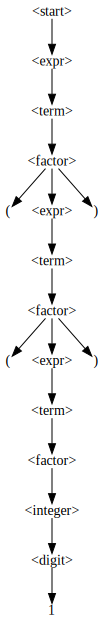

In [202]:
display_tree(exprA_tree)

In [203]:
def Ns(expr, paths):
    for path in paths:
        n = find_node(expr, path)
        print(n[0], tree_to_str(n))

In [204]:
abs_path_A = [0,0,0,1,0,0,1]
Ns(exprA_tree, [abs_path_A])

<expr> 1


In [205]:
FtA = mark_abstract_nodes(exprA_tree, [abs_path_A])
Ta(FtA)

'((<expr>))'

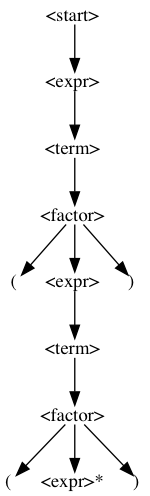

In [206]:
Da(FtA)

In [207]:
FpA = find_charecterizing_node(FtA)
faultA_grammar_, faultA_start = exactly_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, FpA, 'A')
Gs(faultA_grammar_, -1)
faultA_grammar, faultA_start = grammar_gc(faultA_grammar_, faultA_start)
Gs(faultA_grammar)
faultA_start

24 83
<start FA> ::=
|    <expr FA>
<expr FA> ::=
|    <term FA> ' + ' <expr -FA>
|    <term -FA> ' + ' <expr FA>
|    <term FA> ' - ' <expr -FA>
|    <term -FA> ' - ' <expr FA>
|    <term FA>
<term -FA> ::=
|    <factor -FA>
|    <factor -FA> ' * ' <term -FA>
|    <factor -FA> ' / ' <term -FA>
<term FA> ::=
|    <factor FA> ' / ' <term -FA>
|    <factor FA>
|    <factor -FA> ' * ' <term FA>
|    <factor -FA> ' / ' <term FA>
|    <factor FA> ' * ' <term -FA>
<expr -FA> ::=
|    <term -FA> ' - ' <expr -FA>
|    <term -FA> ' + ' <expr -FA>
|    <term -FA>
<factor -FA> ::=
|    '-' <factor -FA>
|    '+' <factor -FA>
|    <integer>
|    <integer> '.' <integer>
|    '(' <expr -FA> ')'
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '4'
|    '6'
|    '1'
|    '5'
|    '7'
|    '0'
|    '8'
|    '3'
|    '2'
|    '9'
<factor FA> ::=
|    '(' <expr LA_1> ')'
|    '-' <factor FA>
|    '+' <factor FA>
<expr LA_1> ::=
|    <term LA_1>
<term LA_1> ::=
|    <factor LA_2>
<factor 

'<start FA>'

In [208]:
faultA_fuzzer = LimitFuzzer(faultA_grammar)
faultA_parser = Parser(faultA_grammar, canonical=True, start_symbol=faultA_start)

In [209]:
for i in range(10):
    s = faultA_fuzzer.fuzz(key=faultA_start)
    print(s)
    assert faultA_parser.can_parse(s)

-+++(8.3 / 2 - 3.8 - 2) / +--781.8 * -+-((1.5)) - (8 - 6.26 - 7 + 6.4 * 4) / +-5
+(63.10 / 7.25 * (9) * 8.7 * 5.5 + 8) - ++--((2)) / 0.5747 * +9.9 * (6.4 * 0.7 - 2 + 7.7) + 9 - 1731 * 1.50
(-+(2 - 7)) - +45.69 / ---5.3 * ((6) / 1 / 6.8) * 1 + 4.165 * ((7)) / -+8.3 - (0.0 * 8.2 * 6.6 + 1.7 / 0.7 + 4) - (0 * 7 - 3 - 7) - (1) / 2.0 * 1 * 0
+((1.0)) / -+-(8.2 * 5.7) + 3.9 * (+5.4 / (9) / 2 / 5) / 670.33 * 5 - 82 * (+3 / 1.9)
(++-1.9 * 1 * -(8.2) * 2 / 8 * 9.2 + -78.85 * +-5 / -2 / 7 * 3) + (+++3) / 6 / -590 / ((4))
((+7 + 9 * 8 - 3 + 6.5))
(+934.6 / 5 * +9.7 * 4 * 9 / 5.2 + 135 / 3 / 8.2 * 1 / 0.4 + +9 - -5.2 - 7 / 2 - 1.3 - 3) - (---2 * 02 * -3 * 1.1 / 8 - 81) * 2 * -(7.7 / 5 + 9.1) * (0 * 3 - 3.8 + 6) / 6 / +1 - (0 + (2.1) * 3 / 6.6) / +(4.2 * 1 + 4 - 5) + (-5.4) / +(9) / ((8)) / -9.4 * 7 / 0.7 - (3.0 + 4.1 + 1.7) / +-9 * 5 / 2 * 9.7
43490 + --((1)) / ((4.6) * 2 + 4 * 6.0 - 9.4 + 9) * +73 / 92 + 30719.6720 + (-0 * 8.8 * 8 - 4 * 2) * (2 * 9 + 1.9) / (4 + 6.6) / -9.4
((8.1)) * (35 / 38.0 *

In [210]:
try:
    for t in faultA_parser.parse('1'):
        print(t)
except SyntaxError as e:
    print(e)

at '1'


## Fault B

In [211]:
exprB_input = '0 + 0'
exprB_tree = list(expr_parser.parse(exprB_input))[0]
tree_to_str(exprB_tree)

'0 + 0'

In [212]:
abs_path_B_a = [0,0]
abs_path_B_b = [0,2,0]
Ns(exprB_tree, [abs_path_B_a, abs_path_B_b])

<term> 0
<term> 0


In [213]:
FtB = mark_abstract_nodes(exprB_tree, [abs_path_B_a, abs_path_B_b])
Ta(FtB)

'<term> + <term>'

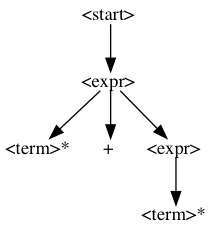

In [214]:
Da(FtB)

In [215]:
FpB = find_charecterizing_node(FtB)
faultB_grammar_, faultB_start  = exactly_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, FpB, 'B', log=True)
Gs(faultB_grammar_, -1)
faultB_grammar, faultB_start = grammar_gc(faultB_grammar_, faultB_start)
Gs(faultB_grammar)
faultB_start

Characterizing Node: <expr FB>
Replacing Key: <expr LB_1>
20 73
<start FB> ::=
|    <expr FB>
<expr FB> ::=
|    <term -FB> ' + ' <expr FB>
|    <term FB> ' + ' <expr -FB>
|    <term -FB> ' - ' <expr FB>
|    <term FB> ' - ' <expr -FB>
|    <term> ' + ' <expr LB_2>
<term -FB> ::=
|    <factor -FB> ' * ' <term -FB>
|    <factor -FB>
|    <factor -FB> ' / ' <term -FB>
<term FB> ::=
|    <factor -FB> ' * ' <term FB>
|    <factor FB>
|    <factor FB> ' * ' <term -FB>
|    <factor FB> ' / ' <term -FB>
|    <factor -FB> ' / ' <term FB>
<expr -FB> ::=
|    <term -FB>
|    <term -FB> ' + ' <expr -FB>
|    <term -FB> ' - ' <expr -FB>
<term> ::=
|    <factor> ' / ' <term>
|    <factor> ' * ' <term>
|    <factor>
<expr LB_2> ::=
|    <term>
<factor -FB> ::=
|    '+' <factor -FB>
|    <integer>
|    <integer> '.' <integer>
|    '-' <factor -FB>
|    '(' <expr -FB> ')'
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '4'
|    '6'
|    '1'
|    '5'
|    '7'
|    '0'
|    '8'
|    '

'<start FB>'

In [216]:
faultB_fuzzer = LimitFuzzer(faultB_grammar)
faultB_parser = Parser(faultB_grammar, canonical=True, start_symbol=faultB_start)

In [217]:
for i in range(10):
    s = faultB_fuzzer.fuzz(key=faultB_start)
    print(s)
    assert faultB_parser.can_parse(s)

--6 / 8.9 * -+(6 * 3 + 3.3 - 6) + 6 + 2 / 91
--+--(1.8 - 8 + 0.0) + +(+3.0 / 3.6 * 5.0 * 8.4 - (3.9) * 6 / 9) / -(-0.0 / 8.8 / 8.3 + 3.8 / 6.9 - 3 + 2) * 9.07 / (0.0 + 1.2 + 0.5) - +4.066 * 1141 * (3 + 8.4) / 20 / +7.5 - ++-+1.0 * -06.9 / (3.9 + 9) * 1 * 7 * 8.8
-+(+-7 * (8.9) + -1.2 * 8.5) / 5 + +(0.5 / +6 + 9 * 0.8 + 5 + 2.6 + 6) / 83 * 65.78 * 169.783 * (5.9) / 2 * 3.7 / 3
+278 / 22819.4 - +055 / 0.60 * 36 / --6 / (8.8 + 2) * (1.7) / 1 + --++(2.5 + 9.4) + 0 * (6 * 4.3) / 06 / 1 - 145 / 56 * 0.2 * 7 * 5 - (1 + 8.9) * (8.9) / 1
(8.69 - +96) / -+--(7 / (1 + 8) * 9.1 + 7.2) / -+(5.8 / 5) * -598 * (9.9 - 5) / +(7.2) * 6 + 7 / ++3 * 5.3 + 0.5
1 * -++00.1 / (+(9.0) / 4 * 3 / 3 - 9 * 1 / 0.9 + 5.2 / 8.2 + 6) + +--7
--+(-7 * 8 * 5.1 + 9.5 * (8 + 4.6) + 5.5 + 4) / --83 / -+-(8.8) * -+++7 / 1.9 * +6 + 1 * 02 - 311.1
-(+49.5 * 83.4 - (6 + 6)) - 3 / -0 / 29 * 5 / --8 / (0.9) / 1 / 2 + -(8.4 * 9.5 - 1 / (6.9 + 5.6) * 6.3 + 9 + 7.5) / +081.0 * 7 / 16.89 / 3 * 7.0 / 6.0 - 07
890 / ---(7 / 3) / --(4

In [218]:
try:
    for t in faultB_parser.parse('1 - 2'):
        print(t)
except SyntaxError as e:
    print(e)

at '1 - 2'


## Fault C

In [219]:
exprC_input = '1 / 0'
exprC_tree = list(expr_parser.parse(exprC_input))[0]
tree_to_str(exprC_tree)

'1 / 0'

In [220]:
abs_path_C = [0,0, 0]
Ns(exprC_tree, [abs_path_C])

<factor> 1


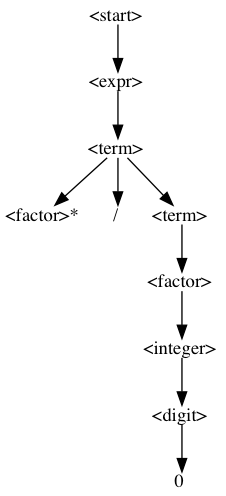

In [221]:
FtC = mark_abstract_nodes(exprC_tree, [abs_path_C])
Da(FtC)

In [222]:
FpC = find_charecterizing_node(FtC)
faultC_grammar_, faultC_start = exactly_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, FpC, 'C')
Gs(faultC_grammar_, -1)
faultC_grammar, faultC_start = grammar_gc(faultC_grammar_, faultC_start)
Gs(faultC_grammar)
faultC_start

26 93
<start FC> ::=
|    <expr FC>
<expr FC> ::=
|    <term FC>
|    <term FC> ' + ' <expr -FC>
|    <term FC> ' - ' <expr -FC>
|    <term -FC> ' + ' <expr FC>
|    <term -FC> ' - ' <expr FC>
<term -FC> ::=
|    <factor -FC> ' / ' <term -FC>
|    <factor -FC>
|    <factor -FC> ' * ' <term -FC>
<term FC> ::=
|    <factor -FC> ' / ' <term FC>
|    <factor> ' / ' <term LC_2>
|    <factor FC> ' * ' <term -FC>
|    <factor FC> ' / ' <term -FC>
|    <factor -FC> ' * ' <term FC>
<expr -FC> ::=
|    <term -FC> ' + ' <expr -FC>
|    <term -FC> ' - ' <expr -FC>
|    <term -FC>
<factor -FC> ::=
|    '+' <factor -FC>
|    '-' <factor -FC>
|    '(' <expr -FC> ')'
|    <integer>
|    <integer> '.' <integer>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '4'
|    '6'
|    '1'
|    '5'
|    '7'
|    '0'
|    '8'
|    '3'
|    '2'
|    '9'
<factor FC> ::=
|    '-' <factor FC>
|    '+' <factor FC>
|    '(' <expr FC> ')'
<factor> ::=
|    '-' <factor>
|    <integer>
|    <integer> '.

'<start FC>'

In [223]:
faultC_fuzzer = LimitFuzzer(faultC_grammar)
faultC_parser = Parser(faultC_grammar, canonical=True, start_symbol=faultC_start)

In [224]:
for i in range(10):
    s = faultC_fuzzer.fuzz(key=faultC_start)
    print(s)
    assert faultC_parser.can_parse(s)

+(-(0 + 9.6 + 8 - 9.7 - 5) + 1 - 3.8 / 0 + 4.4 - 9.3 + 7 - 5.0 - 8.4) / 953527.609 * 35.8 * (+1.1 - 6 / 3.9 - 3 + 7 + 2.9) / -(5.8 - 2 - 9.8 + 3.8 + 0.7 - 5 + 9 - 4 + 0.5) * ++1.6 + (0 / (2 - 1) - (7 - 0) / 8.7 * 3 / 7.8 + 1 / 7.8 * 0.7 + 3.8 - 0.9 - 0 + 0.1) * ++8 * 2.948
++12 * -((1 - 5.1 / 0) / (2)) * 0 * (2.6 * 6.7 / 4 + 8.4) * 4 / +9 * (3.5 + 2 - 6 - 1.3 + 7.1) + (8.9 * 63.1 * (1.3 + 1.4) / 8.6 / 3 + ++6 * 7 * 2.6 - 3 / 0.4 + 7.0 + 5.7 + 1.3 - 0) * 94 - 0 * 05.3 / (7 - 1 + 2.0 - 7 + 0 + 2.1) + --63.3 / 7.8 / (1 + 6.5) * -4 / 6.0 / 7 - -3.57
(613 + ++6.6 * +(5.8)) / 0.41308 + (++9 / 10 + -(5) / +7.1 * 6 / 3.3) * +-(9 / 0 - 6 + 7.0 + 9.1) / (8.7 / 7.3)
---2 * 96 + -++(7.3 - 5.1 / 0) / (0 - 7 * 7.8 / 7 + 8) * 3 / -4.0 * 56 + (+6 * +5.5 / 3.6 * 1.1 + 4 / 4 * 5.6 - 6.3 / 9.1 + 9 - 9 - 2) / 82 - +9.710 / +6 - 6.64 + 88 * +4 + 1 / 0 * 2
659 / --79 * (+(4) / (8 - 5) / 9.2 / 4 - (2.9 / 0) / 6 / 9.7) / 7.5 / 1 + -(52.73 / (1.6 - 7.8) + 4.3 * 0.9 / 7.2)
99 * -+(9 / 4 * 2.6 / 0 + 1.1 - 8.7 - 

In [225]:
try:
    for t in faultC_parser.parse('1 - 2'):
        print(t)
except SyntaxError as e:
    print(e)

at '1 - 2'


## Conjunction

### A & B

In [226]:
AandB_grammar_, AandB_start = and_grammars(faultA_grammar, faultA_start, faultB_grammar, faultB_start)
Gs(AandB_grammar_, -1)
AandB_grammar, AandB_start = grammar_gc(AandB_grammar_, AandB_start)
Gs(AandB_grammar)
AandB_start

43 143
<start and(FA,FB)> ::=
|    <expr and(FA,FB)>
<expr and(FA,FB)> ::=
|    <term and(-FA,)> ' + ' <expr and(FA,LB_2)>
|    <term and(-FA,-FB)> ' - ' <expr and(FA,FB)>
|    <term and(FA,FB)> ' - ' <expr and(-FA,-FB)>
|    <term and(FA,FB)> ' + ' <expr and(-FA,-FB)>
|    <term and(-FA,-FB)> ' + ' <expr and(FA,FB)>
<term and(-FA,)> ::=
|    <factor and(-FA,)> ' / ' <term and(-FA,)>
|    <factor and(-FA,)> ' * ' <term and(-FA,)>
|    <factor and(-FA,)>
<expr and(FA,LB_2)> ::=
|    <term and(FA,)>
<term and(-FA,-FB)> ::=
|    <factor and(-FA,-FB)> ' * ' <term and(-FA,-FB)>
|    <factor and(-FA,-FB)> ' / ' <term and(-FA,-FB)>
|    <factor and(-FA,-FB)>
<term and(FA,FB)> ::=
|    <factor and(-FA,FB)> ' / ' <term and(FA,-FB)>
|    <factor and(FA,FB)> ' / ' <term and(-FA,-FB)>
|    <factor and(FA,-FB)> ' / ' <term and(-FA,FB)>
|    <factor and(FA,FB)> ' * ' <term and(-FA,-FB)>
|    <factor and(-FA,-FB)> ' / ' <term and(FA,FB)>
|    <factor and(FA,-FB)> ' * ' <term and(-FA,FB)>
|    <factor

'<start and(FA,FB)>'

In [227]:
AandB_fuzzer = LimitFuzzer(AandB_grammar)
AandB_parser = Parser(AandB_grammar, canonical=True, start_symbol=AandB_start)

In [228]:
for i in range(10):
    s = AandB_fuzzer.fuzz(key=AandB_start, max_depth=0)
    print(s)
    print('A&B')
    assert AandB_parser.can_parse(s)
    print('A')
    faultA_parser.can_parse(s)
    print('B')
    faultB_parser.can_parse(s)

7 + ((7.5)) * 3.2
A&B
A
B
9 + ((0))
A&B
A
B
9.4 + ((5)) * 0.6
A&B
A
B
3.6 + ((4.4)) / 1.7
A&B
A
B
4 + ((0.4))
A&B
A
B
7.7 + ((5.8))
A&B
A
B
7.4 + ((9))
A&B
A
B
5 + ((6.3)) / 9.2
A&B
A
B
5.9 + ((6.1)) / 3
A&B
A
B
5.1 + ((9.0))
A&B
A
B


### A & C

In [229]:
AandC_grammar_, AandC_start = and_grammars(faultA_grammar, faultA_start, faultC_grammar, faultC_start)
Gs(AandC_grammar_, -1)
AandC_grammar, AandC_start = grammar_gc(AandC_grammar_, AandC_start)
Gs(AandC_grammar)
AandC_start

49 147
<start and(FA,FC)> ::=
|    <expr and(FA,FC)>
<expr and(FA,FC)> ::=
|    <term and(-FA,-FC)> ' - ' <expr and(FA,FC)>
|    <term and(-FA,-FC)> ' + ' <expr and(FA,FC)>
|    <term and(FA,FC)> ' - ' <expr and(-FA,-FC)>
|    <term and(FA,FC)> ' + ' <expr and(-FA,-FC)>
|    <term and(FA,FC)>
<term and(-FA,-FC)> ::=
|    <factor and(-FA,-FC)> ' * ' <term and(-FA,-FC)>
|    <factor and(-FA,-FC)> ' / ' <term and(-FA,-FC)>
|    <factor and(-FA,-FC)>
<term and(FA,FC)> ::=
|    <factor and(FA,)> ' / ' <term and(-FA,LC_2)>
|    <factor and(-FA,-FC)> ' * ' <term and(FA,FC)>
|    <factor and(-FA,-FC)> ' / ' <term and(FA,FC)>
|    <factor and(FA,-FC)> ' * ' <term and(-FA,FC)>
|    <factor and(FA,-FC)> ' / ' <term and(-FA,FC)>
|    <factor and(-FA,FC)> ' / ' <term and(FA,-FC)>
|    <factor and(FA,FC)> ' / ' <term and(-FA,-FC)>
|    <factor and(FA,FC)> ' * ' <term and(-FA,-FC)>
|    <factor and(-FA,FC)> ' * ' <term and(FA,-FC)>
<expr and(-FA,-FC)> ::=
|    <term and(-FA,-FC)>
|    <term and(-FA,-

'<start and(FA,FC)>'

In [230]:
AandC_fuzzer = LimitFuzzer(AandC_grammar)
AandC_parser = Parser(AandC_grammar, canonical=True, start_symbol=AandC_start)

In [231]:
for i in range(10):
    s = AandC_fuzzer.fuzz(key=AandC_start, max_depth=0)
    print(s)
    print('A&C')
    assert AandC_parser.can_parse(s)
    print('A')
    assert faultA_parser.can_parse(s)
    print('C')
    assert faultC_parser.can_parse(s)

((2)) / 0
A&C
A
C
((1.3)) / 0
A&C
A
C
((5)) / 0
A&C
A
C
((8.4)) / 0
A&C
A
C
((6.3)) / 0
A&C
A
C
((6)) / 0
A&C
A
C
((1.5)) / 0
A&C
A
C
((2.2)) / 0
A&C
A
C
((6.9)) / 0
A&C
A
C
((8.0)) / 0
A&C
A
C


### B & C

In [232]:
BandC_grammar_, BandC_start = and_grammars(faultB_grammar, faultB_start, faultC_grammar, faultC_start)
Gs(BandC_grammar_, -1)
BandC_grammar, BandC_start = grammar_gc(BandC_grammar_, BandC_start)
Gs(BandC_grammar)
BandC_start

41 142
<start and(FB,FC)> ::=
|    <expr and(FB,FC)>
<expr and(FB,FC)> ::=
|    <term and(-FB,-FC)> ' - ' <expr and(FB,FC)>
|    <term and(FB,FC)> ' + ' <expr and(-FB,-FC)>
|    <term and(FB,FC)> ' - ' <expr and(-FB,-FC)>
|    <term and(,-FC)> ' + ' <expr and(LB_2,FC)>
|    <term and(-FB,-FC)> ' + ' <expr and(FB,FC)>
<term and(,-FC)> ::=
|    <factor and(,-FC)>
|    <factor and(,-FC)> ' / ' <term and(,-FC)>
|    <factor and(,-FC)> ' * ' <term and(,-FC)>
<expr and(LB_2,FC)> ::=
|    <term and(,FC)>
<term and(-FB,-FC)> ::=
|    <factor and(-FB,-FC)>
|    <factor and(-FB,-FC)> ' * ' <term and(-FB,-FC)>
|    <factor and(-FB,-FC)> ' / ' <term and(-FB,-FC)>
<term and(FB,FC)> ::=
|    <factor and(FB,FC)> ' / ' <term and(-FB,-FC)>
|    <factor and(FB,)> ' / ' <term and(-FB,LC_2)>
|    <factor and(FB,-FC)> ' * ' <term and(-FB,FC)>
|    <factor and(FB,-FC)> ' / ' <term and(-FB,FC)>
|    <factor and(-FB,FC)> ' / ' <term and(FB,-FC)>
|    <factor and(FB,FC)> ' * ' <term and(-FB,-FC)>
|    <factor 

'<start and(FB,FC)>'

In [233]:
BandC_fuzzer = LimitFuzzer(BandC_grammar)
BandC_parser = Parser(BandC_grammar, canonical=True, start_symbol=BandC_start)

In [ ]:
for i in range(10):
    s = BandC_fuzzer.fuzz(key=BandC_start, max_depth=0)
    print(s)
    print('B&C')
    assert BandC_parser.can_parse(s)
    print('B')
    assert faultB_parser.can_parse(s)
    print('C')
    assert faultC_parser.can_parse(s)

(3 + 1.5) / 1 / 0 + 7
B&C
B
C
(7.8 + 3.6) / 0 + 4.1
B&C
B
C
(5 + 6) * 4.5 / 0 - 0.6
B&C
B
C
7.2 - (4 + 8.1) / 4.7 / 0 - 5.8
B&C
B
C


## Disjunction

### A | B

In [ ]:
AorB_grammar_, AorB_start = or_grammars(faultA_grammar, faultA_start, faultB_grammar, faultB_start)
Gs(AorB_grammar_, -1)
AorB_grammar, AorB_start = grammar_gc(AorB_grammar_, AorB_start)
Gs(AorB_grammar)
AorB_start

In [ ]:
AorB_fuzzer = LimitFuzzer(AorB_grammar)
AorB_parser = Parser(AorB_grammar, canonical=True, start_symbol=AorB_start)

In [ ]:
for i in range(10):
    s = AorB_fuzzer.fuzz(key=AorB_start)
    print(s)
    print('A|B')
    assert AorB_parser.can_parse(s)
    print('A', A_parser.can_parse(s))
    print('B', B_parser.can_parse(s))

### A | C

In [ ]:
AorC_grammar_, AorC_start = or_grammars(faultA_grammar, faultA_start, faultC_grammar, faultC_start)
Gs(AorC_grammar_, -1)
AorC_grammar, AorC_start = grammar_gc(AorC_grammar_, AorC_start)
Gs(AorC_grammar)
AorC_start

In [ ]:
AorC_fuzzer = LimitFuzzer(AorC_grammar)
AorC_parser = Parser(AorC_grammar, canonical=True, start_symbol=AorC_start)

In [ ]:
for i in range(10):
    s = AorC_fuzzer.fuzz(key=AorC_start)
    print(s)
    print('A|C')
    assert AorC_parser.can_parse(s)
    print('A', A_parser.can_parse(s))
    print('C', C_parser.can_parse(s))

### B | C

In [ ]:
BorC_grammar_, BorC_start = or_grammars(faultB_grammar, faultB_start, faultC_grammar, faultC_start)
Gs(BorC_grammar_, -1)
BorC_grammar, BorC_start = grammar_gc(BorC_grammar_, BorC_start)
Gs(BorC_grammar)
BorC_start

In [ ]:
BorC_fuzzer = LimitFuzzer(BorC_grammar)
BorC_parser = Parser(BorC_grammar, canonical=True, start_symbol=BorC_start)

In [ ]:
for i in range(10):
    s = BorC_fuzzer.fuzz(key=BorC_start)
    print(s)
    print('B|C')
    assert BorC_parser.can_parse(s)
    print('B', B_parser.can_parse(s))
    print('C', C_parser.can_parse(s))

## Negation

### A - B

In [ ]:
AminusB_grammar_, AminusB_start = difference_grammars(faultA_grammar, faultA_start, faultB_grammar, faultB_start)
Gs(AminusB_grammar_, -1)
AminusB_grammar, AminusB_start = grammar_gc(AminusB_grammar_, AminusB_start)
Gs(AminusB_grammar)
AminusB_start

In [ ]:
AminusB_fuzzer = LimitFuzzer(AminusB_grammar)
AminusB_parser = Parser(AminusB_grammar, canonical=True, start_symbol=AminusB_start)

In [ ]:
for i in range(100):
    s = AminusB_fuzzer.fuzz(key=AorB_start)
    print(s)
    print('A-B')
    assert AminusB_parser.can_parse(s)
    print('A')
    assert faultA_parser.can_parse(s)
    print('-B')
    assert not faultB_parser.can_parse(s)

### A - C

In [ ]:
AminusC_grammar_, AorC_start = difference_grammars(faultA_grammar, faultA_start, faultC_grammar, faultC_start)
Gs(AminusC_grammar_, -1)
AminusC_grammar, AminusC_start = grammar_gc(AminusC_grammar_, AminusC_start)
Gs(AminusC_grammar)
AminusC_start

In [ ]:
AminusC_fuzzer = LimitFuzzer(AminusC_grammar)
AminusC_parser = Parser(AminusC_grammar, canonical=True, start_symbol=AminusC_start)

In [ ]:
for i in range(10):
    s = AminusC_fuzzer.fuzz(key=AminusC_start)
    print(s)
    print('A-C')
    assert AorC_parser.can_parse(s)
    print('A')
    assert faultA_parser.can_parse(s)
    print('-C')
    assert not faultC_parser.can_parse(s)

### B - C

In [ ]:
BminusC_grammar_, BminusC_start = difference_grammars(faultB_grammar, faultB_start, faultC_grammar, faultC_start)
Gs(BminusC_grammar_, -1)
BminusC_grammar, BminusC_start = grammar_gc(BminusC_grammar_, BminusC_start)
Gs(BminusC_grammar)
BminusC_start

In [ ]:
BminusC_fuzzer = LimitFuzzer(BminusC_grammar)
BminusC_parser = Parser(BminusC_grammar, canonical=True, start_symbol=BminusC_start)

In [ ]:
for i in range(10):
    s = BorC_fuzzer.fuzz(key=BorC_start)
    print(s)
    print('B-C')
    assert BminusC_parser.can_parse(s)
    print('B')
    assert B.can_parse(s)
    print('-C')
    assert not C.can_parse(s)